<a href="https://colab.research.google.com/github/cvillela/amplemarket_challenge/blob/main/challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Amplemarket Machine Learning Engineer Challenge

Caio Simão Villela - csvillela1@gmail.com

---

# B2B and B2C Classification Model for Companies

This project aims to create a classification model that can differentiate between B2B (business-to-business) and B2C (business-to-consumer) companies based on their company profile data.

The model is developed using XGBoost, an efficient implementation of gradient boosting algorithms that has gained popularity due to its high accuracy and fast computation. To improve the model's performance, Optuna, an automatic hyperparameter optimization framework, is used to find the optimal set of hyperparameters for the model.

Users will be able to input a company's profile data, and the model will classify it as B2B, B2C, both or neither.

Two different models will be used for this multi-label classification, using a technique known as [....] for [....]

# Installs
---

In [1]:
!pip install optuna
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 14.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.5 MB/s eta 0:00:00


## Imports
---

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import gspread

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import optuna
import torch
from tqdm import tqdm
import torch

In [6]:
device_id = torch.cuda.current_device() if torch.cuda.is_available() else -1

In [7]:
device_id

0

In [126]:
sns.set_style('darkgrid')

# Import the Data
---

Since I did not want to create a public URL containing the provided Amplemarket company dataset, I am going to manually update the dataset contained in the github repository / provided google sheets.

In [8]:
from google.colab import files 
 
uploaded = files.upload()

Saving data.csv to data.csv


# Exploratory Data Analysis
---

In [9]:
def remove_top_outliers(df, column_name, percentage):
    print('dataframe shape - before', df.shape)
    percentage = percentage*0.01
    df = df[df[column_name] < df[column_name].quantile(1-percentage)]
    print('dataframe shape - after', df.shape)
    return(df)

In [10]:
df = pd.read_csv('./data.csv')

In [11]:
pd.set_option('display.max_columns', None)

In [12]:
df.head()

,name,alexa_rank,city,state,country,hq,website,employees_on_linkedin,followers,founded,industry,linkedin_url,overview,ownership_type,sic_codes,size,specialties,total_funding,technologies,company_hubs,events,categories,type
0,Supli,NaN,Paris,√éle-de-France,France,"Paris, √éle-de-France",https://supli.com/,22,1074,2017.0,Restaurants,https://www.linkedin.com/company/supli,Lib√©rez votre activit√© avec la plateforme de...,Partnership,NaN,11-50 employees,"saas, ERP, plateforme, restauration, grossiste...",0,NaN,NaN,NaN,NaN,B2B
1,Bandwidth Recruitment,NaN,Hove,England,United Kingdom,"Hove, East Sussex",http://www.bandwidthrecruitment.com,2,484,2009.0,Staffing and Recruiting,https://www.linkedin.com/company/bandwidth-rec...,Bandwidth Recruitment is an independent specia...,Privately Held,NaN,2-10 employees,Cards and payments recruitment,0,"New Relic, YouTube, Eventbrite, Microsoft Offi...",NaN,PAY 360,"Consulting, Human Resources, Insurance, Small ...",B2B
2,VCV.AI,NaN,Menlo Park,California,United States,"Menlo Park, California",http://vcv.ai/,40,877,2017.0,Information Technology and Services,https://www.linkedin.com/company/vcv-ai,VCV automates 4 steps of recruitment in one fr...,Privately Held,NaN,11-50 employees,"assessment, recruitment, selection, hiring, HR...",150000,Amazon SES,"Companies with a .AI domain, Growjo 10000, 500...",NaN,"Artificial Intelligence, Recruiting, Human Res...",B2B
3,"Scalable Press Employees, Location, Careers",NaN,Newark,California,United States,"Newark, California",https://scalablepress.com,112,11322,2012.0,Printing,https://www.linkedin.com/company/scalablepress,At Scalable Press we're building the next gene...,Public Company,NaN,501-1000 employees,"Promotional Products Supplier, Industrial Auto...",0,"HubSpot, New Relic, React, Salesforce, Sendgri...",NaN,Integrated Systems Europe 2020,"Software Engineering, Retail Technology, Indus...",B2B B2C
4,Stuffwrap,NaN,NaN,NaN,Unknown,Unknown,http://www.stuffwrap.com,0,21,2012.0,Information Services,https://www.linkedin.com/company/stuffwrap,Stuffwrap is a platform where you turn your wi...,Public Company,NaN,2-10 employees,"Sale and swap your stuff, Buying and selling, ...",0,Microsoft ASP.NET,NaN,NaN,"Information Services, Social Network,",B2C


In [13]:
df.columns

Index(['name', 'alexa_rank', 'city', 'state', 'country', 'hq', 'website',
       'employees_on_linkedin', 'followers', 'founded', 'industry',
       'linkedin_url', 'overview', 'ownership_type', 'sic_codes', 'size',
       'specialties', 'total_funding', 'technologies', 'company_hubs',
       'events', 'categories', 'type'],
      dtype='object')

In [14]:
df.columns

Index(['name', 'alexa_rank', 'city', 'state', 'country', 'hq', 'website',
       'employees_on_linkedin', 'followers', 'founded', 'industry',
       'linkedin_url', 'overview', 'ownership_type', 'sic_codes', 'size',
       'specialties', 'total_funding', 'technologies', 'company_hubs',
       'events', 'categories', 'type'],
      dtype='object')

In [15]:
df.describe()

,alexa_rank,employees_on_linkedin,followers,founded,total_funding
count,214.000000,1799.000000,1799.000000,1543.000000,1.799000e+03
mean,415985.294393,43.559755,1504.840467,2010.705768,3.039968e+07
std,278537.061488,304.762881,5883.113006,12.341825,8.312451e+08
min,33.000000,0.000000,0.000000,1825.000000,0.000000e+00
25%,161458.750000,2.000000,21.000000,2010.000000,0.000000e+00
50%,400686.000000,6.000000,127.000000,2014.000000,0.000000e+00
75%,632575.250000,18.000000,680.500000,2016.000000,0.000000e+00
max,991704.000000,10011.000000,147481.000000,2021.000000,3.395000e+10


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   1799 non-null   object 
 1   alexa_rank             214 non-null    float64
 2   city                   1459 non-null   object 
 3   state                  1426 non-null   object 
 4   country                1699 non-null   object 
 5   hq                     1676 non-null   object 
 6   website                1798 non-null   object 
 7   employees_on_linkedin  1799 non-null   int64  
 8   followers              1799 non-null   int64  
 9   founded                1543 non-null   float64
 10  industry               1771 non-null   object 
 11  linkedin_url           1799 non-null   object 
 12  overview               1773 non-null   object 
 13  ownership_type         1672 non-null   object 
 14  sic_codes              93 non-null     object 
 15  size

In [17]:
df['type'].value_counts(dropna=False)

B2B        1312
B2B B2C     315
B2C         172
Name: type, dtype: int64

### Categorical Flags

In [18]:
df['has_funding'] = 0
df.loc[df['total_funding']>0, 'has_funding'] = 1

In [19]:
df['has_events'] = 0
df.loc[df['events'].notnull(), 'has_events'] = 1

In [20]:
df['has_hubs'] = 0
df.loc[df['company_hubs'].notnull(), 'has_hubs'] = 1

### Subgroups and Biases
---
As the main idea is to create two separate models for multilabel classification (One vs Rest), it is important to check the B2B and B2C populations separately, as to avoid any biases in feature extraction and dataset preprocessing that one of the populations (B2C or B2B) may contain.

For example, one of the features may be preset in one of the populations (events, or company hubs, for example) and not be present in the other. In this case, it would only make sense to exclude this one feature as a model input for one of the models, but not for the other.

In [21]:
df_b2b = df.loc[df['type'].str.contains('B2B')]

In [22]:
df_b2c = df.loc[df['type'].str.contains('B2C')]

In [23]:
df['B2B'] = 0
df.loc[df['type'].str.contains('B2B'), 'B2B'] = 1

df['B2C'] = 0
df.loc[df['type'].str.contains('B2C'), 'B2C'] = 1

### Total Funding 
---

Removing top 1% of total funding values, as the funding is very disperse 

In [24]:
df = remove_top_outliers(df, 'total_funding', 1)

dataframe shape - before (1799, 28)
dataframe shape - after (1781, 28)


In [25]:
df_b2c.has_funding.value_counts()

0    370
1    117
Name: has_funding, dtype: int64

In [26]:
df_b2b.has_funding.value_counts()

0    1224
1     403
Name: has_funding, dtype: int64

<Axes: xlabel='total_funding', ylabel='Density'>

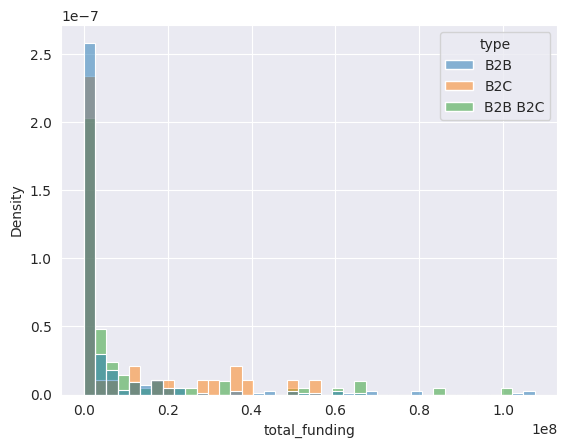

In [171]:
sns.histplot(df.loc[df['has_funding']==1], x='total_funding', bins=40, hue='type', common_norm=False, stat="density")


<Axes: xlabel='total_funding', ylabel='Proportion'>

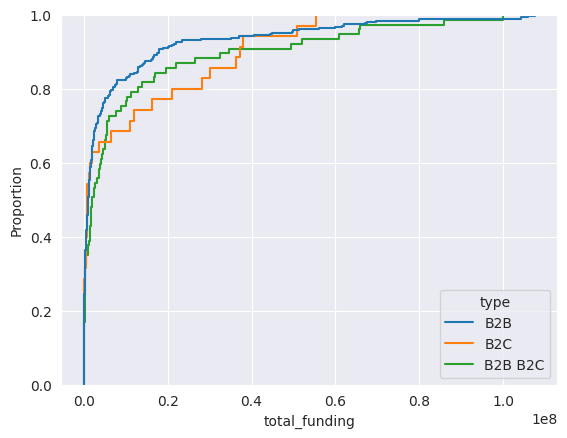

In [173]:
sns.ecdfplot(data=df.loc[df['has_funding']==1], x='total_funding', hue='type')

<Axes: xlabel='total_funding', ylabel='Proportion'>

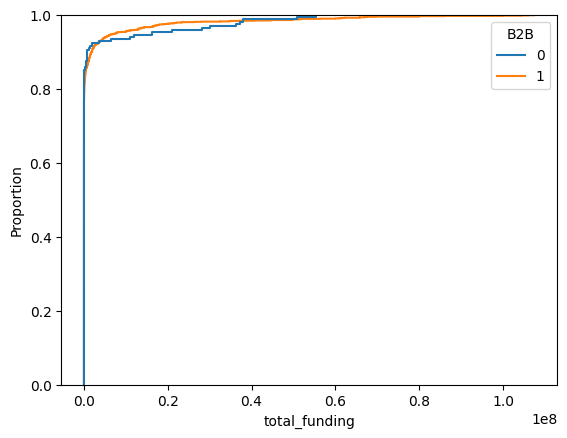

In [29]:
sns.ecdfplot(data=df, x='total_funding', hue='B2B')

<Axes: xlabel='total_funding', ylabel='Proportion'>

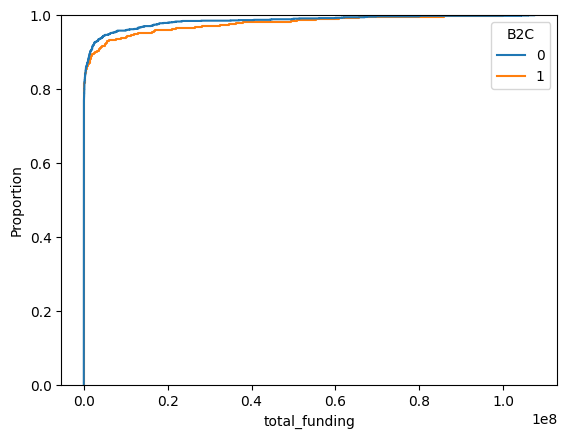

In [30]:
sns.ecdfplot(data=df, x='total_funding', hue='B2C')

By checking the total_funding distributions on both populations, one can conclude that the values are too disperse and probably won't contribute significativelly for model convergence in training. On the other hand, the categorical feature "has_funding" may be useful for fitting, as the majority of companies with funding are B2B. 

<Axes: xlabel='has_funding', ylabel='count'>

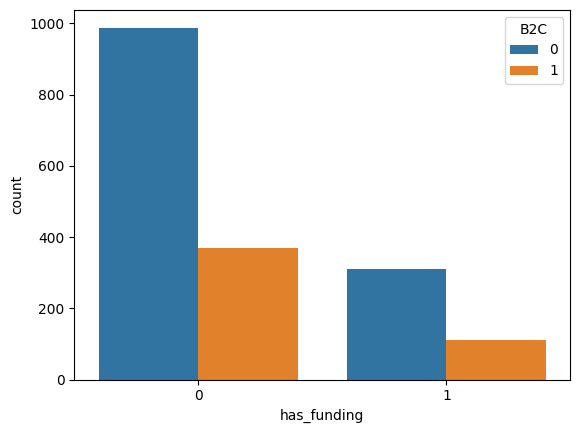

In [31]:
sns.countplot(data=df, x='has_funding', hue='B2C')

<Axes: xlabel='has_funding', ylabel='count'>

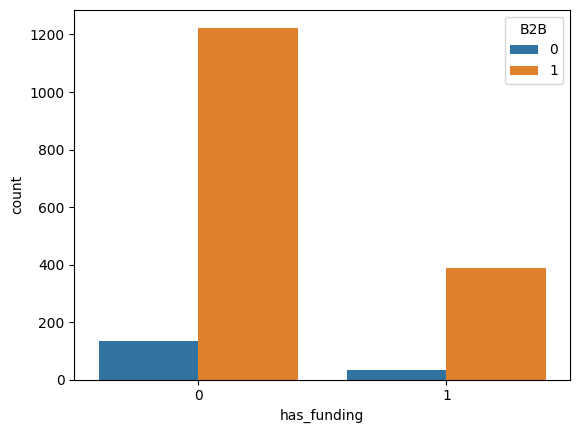

In [32]:
sns.countplot(data=df, x='has_funding', hue='B2B')

<Axes: xlabel='type', ylabel='total_funding'>

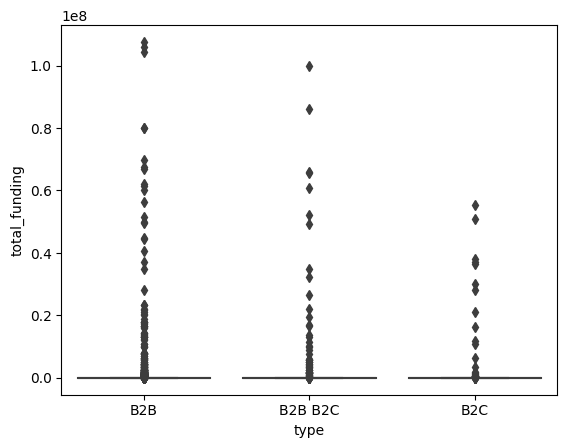

In [33]:
sns.boxplot(data=df, x='type', y='total_funding')

### Founded
---

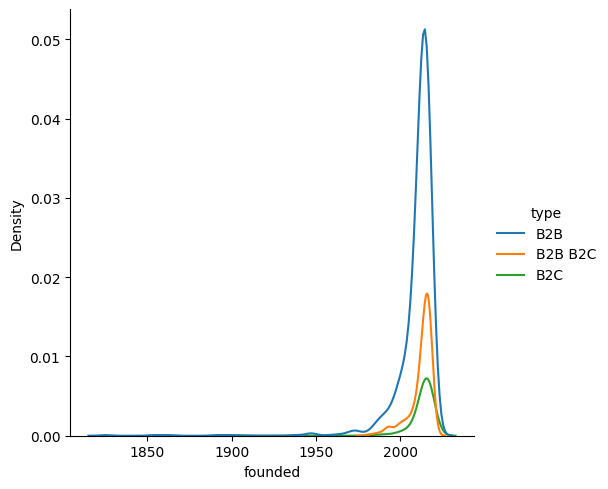

In [34]:
sns.displot(data=df, x='founded', kind='kde', hue='type')

<Axes: xlabel='founded', ylabel='Proportion'>

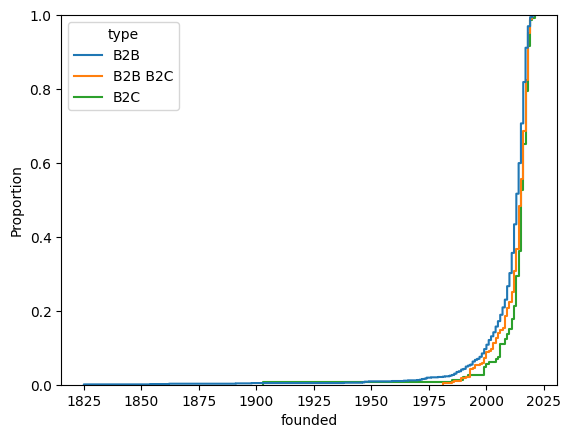

In [35]:
sns.ecdfplot(data=df, x='founded',  hue='type')

<Axes: xlabel='type', ylabel='founded'>

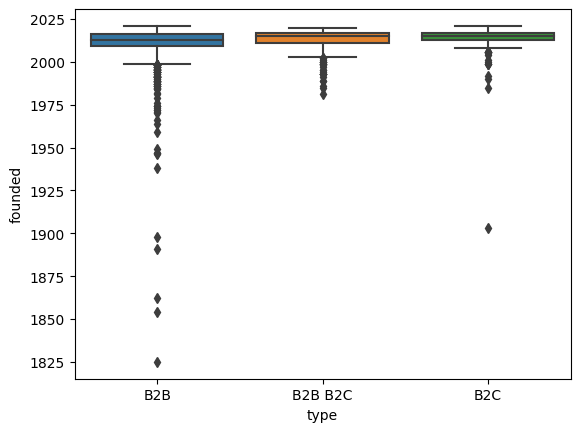

In [36]:
sns.boxplot(data=df, x='type', y='founded')

### Employees
---

In [37]:
# df = remove_top_outliers(df, 'employees_on_linkedin', 0.1)

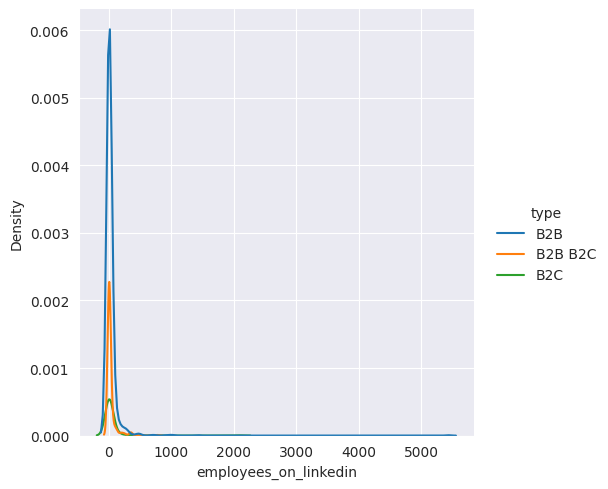

In [176]:
sns.displot(data=df, x='employees_on_linkedin', kind='kde', hue='type')

<Axes: xlabel='employees_on_linkedin', ylabel='Proportion'>

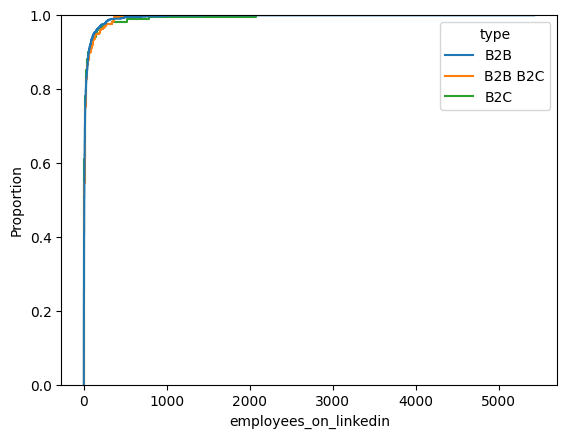

In [39]:
sns.ecdfplot(data=df, x='employees_on_linkedin',  hue='type')

<Axes: xlabel='type', ylabel='employees_on_linkedin'>

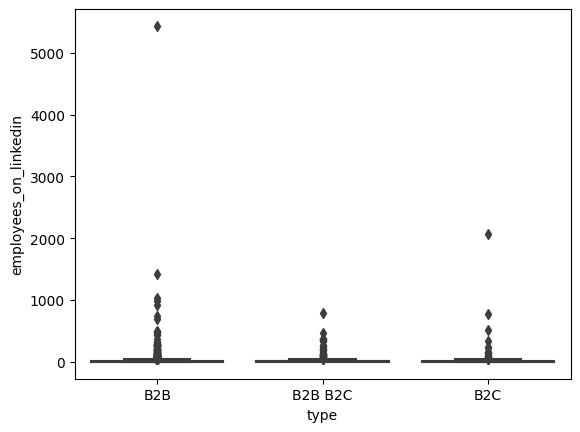

In [40]:
sns.boxplot(data=df, x='type', y='employees_on_linkedin')

### Followers
---

In [41]:
# df = remove_top_outliers(df, 'followers', 0.1)

<Axes: xlabel='followers', ylabel='Density'>

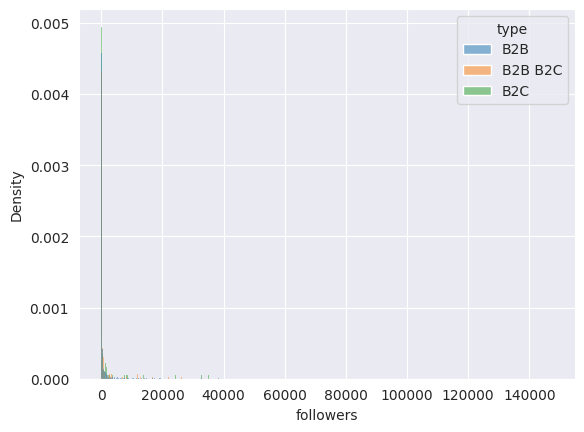

In [178]:
sns.histplot(data=df, x='followers', common_norm=False, stat="density", hue='type')

<Axes: xlabel='followers', ylabel='Proportion'>

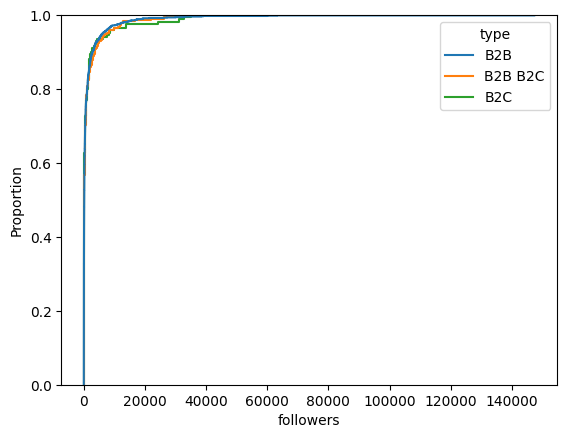

In [43]:
sns.ecdfplot(data=df, x='followers',  hue='type')

<Axes: xlabel='type', ylabel='followers'>

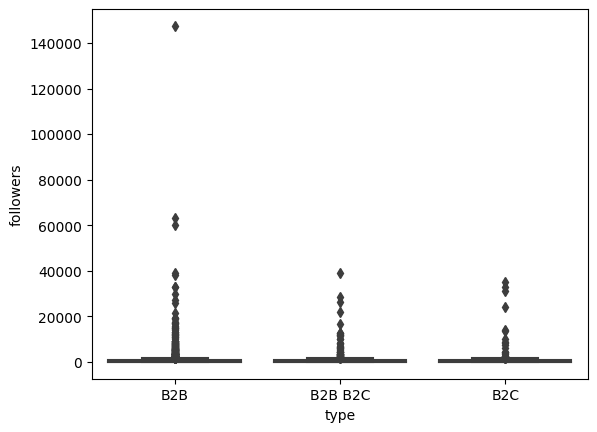

In [44]:
sns.boxplot(data=df, x='type', y='followers')

### Events
---

In [45]:
df.has_events.value_counts()

0    1707
1      74
Name: has_events, dtype: int64

In [46]:
df.loc[df.B2B==1].has_events.value_counts()

0    1543
1      69
Name: has_events, dtype: int64

In [47]:
df.loc[df.B2C==1].has_events.value_counts()

0    462
1     20
Name: has_events, dtype: int64

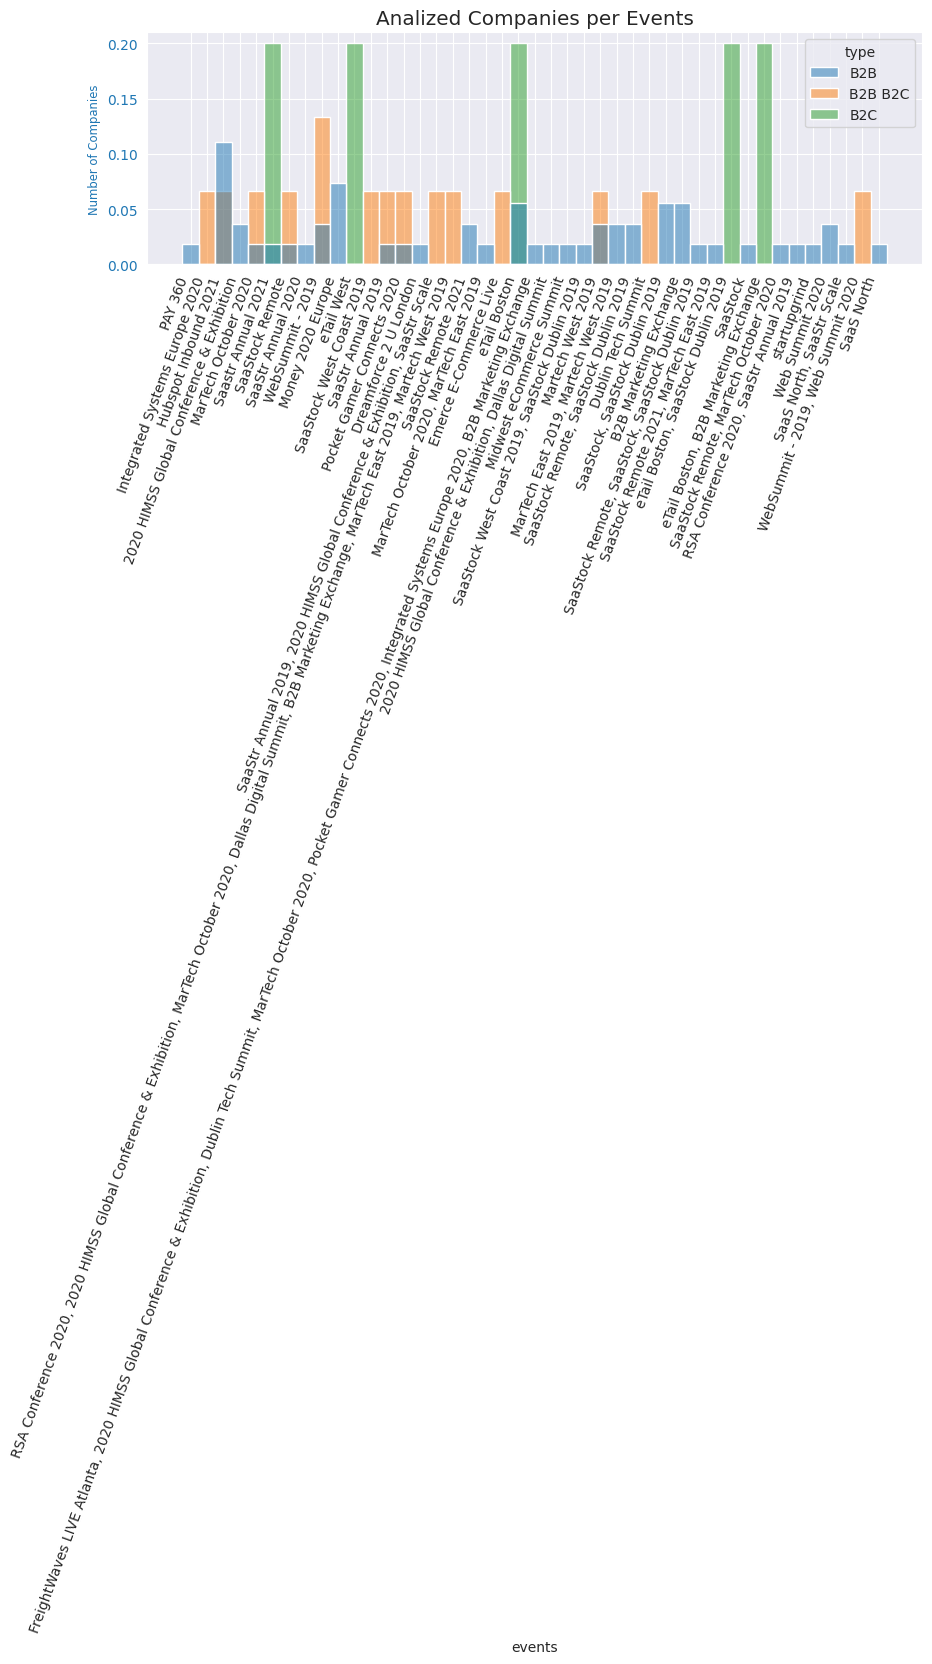

In [179]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))

sns.histplot(data=df, x='events', hue='type', common_norm=False, stat="density")

# # title and axis
ax.set_title('Analized Companies per Events',  size='x-large')
ax.set_ylabel('Number of Companies', size='small', color='C0')
ax.tick_params(axis='y', colors='C0')
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# ax.set_xticks(np.arange(len(list(dict_ret_geral.keys()))))
# ax.set_xticklabels(labels=list(dict_ret_geral.keys()))
plt.setp(ax.get_xticklabels(), rotation=70,  horizontalalignment='right')

plt.gcf().subplots_adjust(bottom=0.3)

plt.show()

### Company Hubs
---

In [49]:
df.has_hubs.value_counts()

0    1454
1     327
Name: has_hubs, dtype: int64

In [50]:
df_b2c["has_hubs"].value_counts(dropna=False)

0    411
1     76
Name: has_hubs, dtype: int64

In [51]:
df_b2b["has_hubs"].value_counts(dropna=False)

0    1311
1     316
Name: has_hubs, dtype: int64

### Countries
---

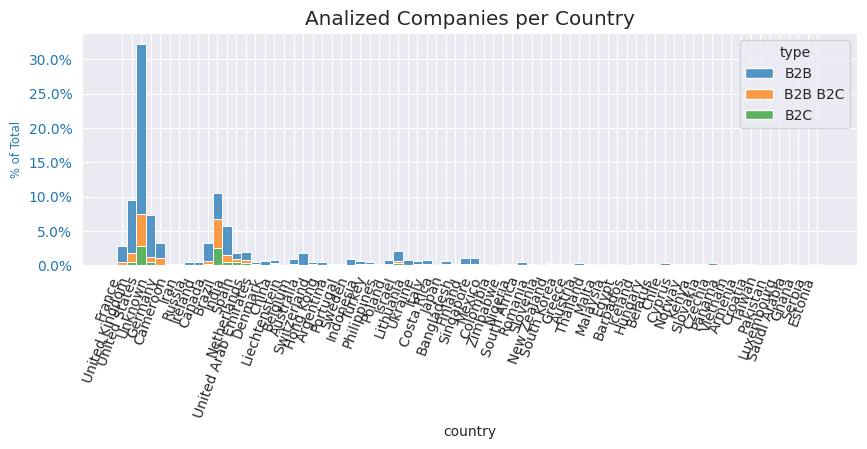

In [182]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))

sns.histplot(data=df, x='country', hue='type', discrete=True, stat='percent', multiple="stack")

# # title and axis
ax.set_title('Analized Companies per Country',  size='x-large')
ax.set_ylabel('% of Total', size='small', color='C0')
ax.tick_params(axis='y', colors='C0')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# ax.set_xticks(np.arange(len(list(dict_ret_geral.keys()))))
# ax.set_xticklabels(labels=list(dict_ret_geral.keys()))
plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right')

plt.gcf().subplots_adjust(bottom=0.3)

plt.show()

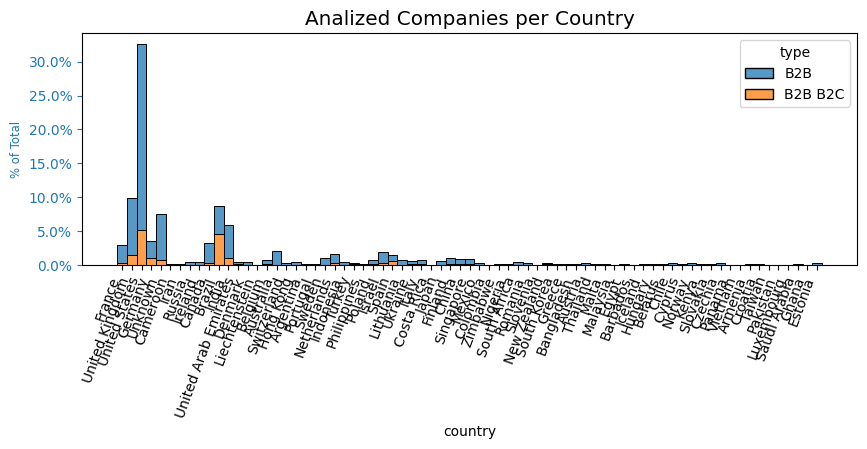

In [53]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))

sns.histplot(data=df_b2b, x='country', hue='type', discrete=True, stat='percent', multiple="stack",)

# # title and axis
ax.set_title('Analized Companies per Country',  size='x-large')
ax.set_ylabel('% of Total', size='small', color='C0')
ax.tick_params(axis='y', colors='C0')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# ax.set_xticks(np.arange(len(list(dict_ret_geral.keys()))))
# ax.set_xticklabels(labels=list(dict_ret_geral.keys()))
plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right')

plt.gcf().subplots_adjust(bottom=0.3)

plt.show()

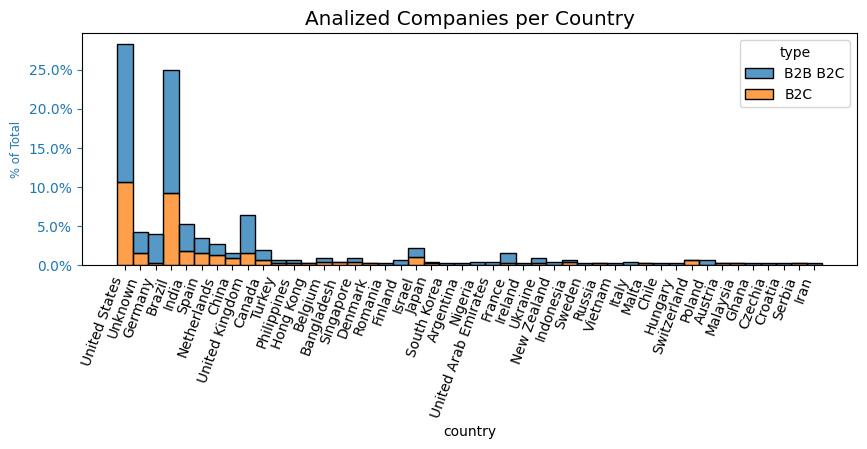

In [54]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))

sns.histplot(data=df_b2c, x='country', hue='type', discrete=True, stat='percent', multiple="stack",)

# # title and axis
ax.set_title('Analized Companies per Country',  size='x-large')
ax.set_ylabel('% of Total', size='small', color='C0')
ax.tick_params(axis='y', colors='C0')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# ax.set_xticks(np.arange(len(list(dict_ret_geral.keys()))))
# ax.set_xticklabels(labels=list(dict_ret_geral.keys()))
plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right')

plt.gcf().subplots_adjust(bottom=0.3)

plt.show()

## Text Features
---

In [55]:
df[['name', 'overview', 'industry', 'specialties', 'technologies', 'categories', 'type']]

,name,overview,industry,specialties,technologies,categories,type
0,Supli,Lib√©rez votre activit√© avec la plateforme de...,Restaurants,"saas, ERP, plateforme, restauration, grossiste...",NaN,NaN,B2B
1,Bandwidth Recruitment,Bandwidth Recruitment is an independent specia...,Staffing and Recruiting,Cards and payments recruitment,"New Relic, YouTube, Eventbrite, Microsoft Offi...","Consulting, Human Resources, Insurance, Small ...",B2B
2,VCV.AI,VCV automates 4 steps of recruitment in one fr...,Information Technology and Services,"assessment, recruitment, selection, hiring, HR...",Amazon SES,"Artificial Intelligence, Recruiting, Human Res...",B2B
3,"Scalable Press Employees, Location, Careers",At Scalable Press we're building the next gene...,Printing,"Promotional Products Supplier, Industrial Auto...","HubSpot, New Relic, React, Salesforce, Sendgri...","Software Engineering, Retail Technology, Indus...",B2B B2C
4,Stuffwrap,Stuffwrap is a platform where you turn your wi...,Information Services,"Sale and swap your stuff, Buying and selling, ...",Microsoft ASP.NET,"Information Services, Social Network,",B2C
...,...,...,...,...,...,...,...
1794,BB Holdings,Innovation | Solutions | Consulting\n\nBusines...,Executive Office,"Wellness Management, Entertainment & Film, and...",Campaign Monitor,"Financial Services,",B2B
1795,Adan Corporate,Adan Corporate provides a wide range of bespok...,Management Consulting,"Mergers & Acquisitions, Financial modelling, S...",NaN,"Information Technology, Consulting, CRM,",B2B
1796,Stafford Consulting Engineers,Stafford Consulting Engineers is headquartered...,Facilities Services,"Forensic Investigations, Roof Asset Management...",NaN,"Construction, Facilities Support Services, , A...",B2B
1797,LeadSecure,LeadSecure is the next evolution in lead gener...,Real Estate,"real estate technology, lead generation","YouTube, Amazon Route 53","Internet, Mobile, Video Streaming, Real Estate,",B2B


# Data Preprocessing - Feature Engineering
---

### Removing Columns

In this step I remove some of the Dataset columns which are not likely to be useful for our model prediction fit.

By removing geospatial data such as City, State, Country and HQ , I also avoid Geospatial Biases to be produced by the model, ....

The company overview does **contain very useful information** on the company "type", but given the unstructured nature of the data and the time constraints on the project at hand, I have decided not to dabble too much on feature engineering over the descriptive texts and disregard the "overview" on my classification model. 

there is also too little data on 'company_hubs', 'events' and 'alexa_ranking' with a significant ammount of missing values for those fields on the provided dataset. For that reason I have also chosen not to use those fields on the company type classification model training.

In [56]:
df_clean = df.drop(columns=['name', 'alexa_rank', 'city', 'state', 'country', 'hq', 'website',
       'linkedin_url', 'overview', 'sic_codes', 'company_hubs', 'events'])

In [57]:
df_clean

,employees_on_linkedin,followers,founded,industry,ownership_type,size,specialties,total_funding,technologies,categories,type,has_funding,has_events,has_hubs,B2B,B2C
0,22,1074,2017.0,Restaurants,Partnership,11-50 employees,"saas, ERP, plateforme, restauration, grossiste...",0,NaN,NaN,B2B,0,0,0,1,0
1,2,484,2009.0,Staffing and Recruiting,Privately Held,2-10 employees,Cards and payments recruitment,0,"New Relic, YouTube, Eventbrite, Microsoft Offi...","Consulting, Human Resources, Insurance, Small ...",B2B,0,1,0,1,0
2,40,877,2017.0,Information Technology and Services,Privately Held,11-50 employees,"assessment, recruitment, selection, hiring, HR...",150000,Amazon SES,"Artificial Intelligence, Recruiting, Human Res...",B2B,1,0,1,1,0
3,112,11322,2012.0,Printing,Public Company,501-1000 employees,"Promotional Products Supplier, Industrial Auto...",0,"HubSpot, New Relic, React, Salesforce, Sendgri...","Software Engineering, Retail Technology, Indus...",B2B B2C,0,1,0,1,1
4,0,21,2012.0,Information Services,Public Company,2-10 employees,"Sale and swap your stuff, Buying and selling, ...",0,Microsoft ASP.NET,"Information Services, Social Network,",B2C,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,2,6,NaN,Executive Office,Privately Held,0-1 employees,"Wellness Management, Entertainment & Film, and...",0,Campaign Monitor,"Financial Services,",B2B,0,0,0,1,0
1795,22,123,2013.0,Management Consulting,Privately Held,NaN,"Mergers & Acquisitions, Financial modelling, S...",0,NaN,"Information Technology, Consulting, CRM,",B2B,0,0,0,1,0
1796,3,89,1964.0,Facilities Services,Privately Held,11-50 employees,"Forensic Investigations, Roof Asset Management...",0,NaN,"Construction, Facilities Support Services, , A...",B2B,0,0,0,1,0
1797,0,15,2014.0,Real Estate,Privately Held,2-10 employees,"real estate technology, lead generation",125000,"YouTube, Amazon Route 53","Internet, Mobile, Video Streaming, Real Estate,",B2B,1,0,0,1,0


### Feature Engineering
---

#### size:
we need to preprocess the strings to exctract information

In [58]:
df_clean['size'] = df_clean['size'].str.replace(r'[^0-9\-]+', '')

<ipython-input-58-1909f25729f6>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean['size'] = df_clean['size'].str.replace(r'[^0-9\-]+', '')


<Axes: xlabel='size', ylabel='Count'>

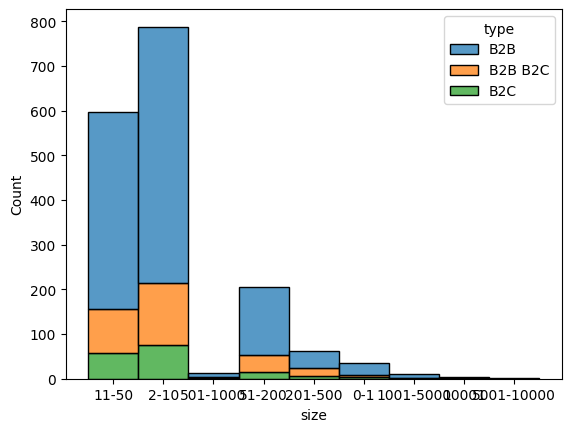

In [59]:
sns.histplot(data=df_clean, x='size', hue='type', multiple='stack')

In [60]:
df_clean.loc[df_clean['size']=='10001', 'size']='500+'
df_clean.loc[df_clean['size']=='5001-10000', 'size']='500+'
df_clean.loc[df_clean['size']=='1001-5000', 'size']='500+'
df_clean.loc[df_clean['size']=='501-1000', 'size']='500+'
df_clean.loc[df_clean['size']=='201-500', 'size']='201-500'
df_clean.loc[df_clean['size']=='0-1', 'size']='1-10'
df_clean.loc[df_clean['size']=='2-10', 'size']='1-10'

In [61]:
df_clean['size'].value_counts()

1-10       823
11-50      596
51-200     206
201-500     61
500+        27
Name: size, dtype: int64

<Axes: xlabel='size', ylabel='Count'>

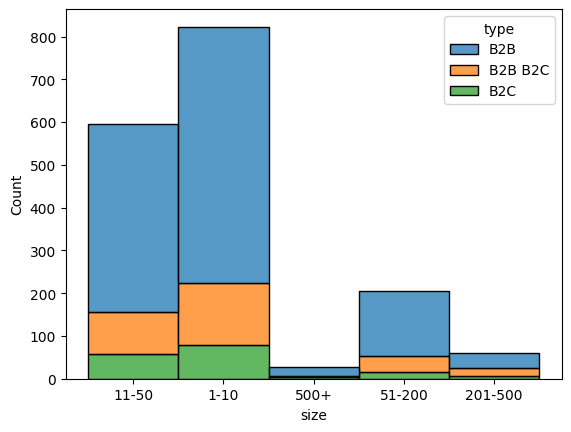

In [62]:
sns.histplot(data=df_clean, x='size', hue='type', multiple='stack')

### ownership_type:

In [213]:
df_clean.ownership_type.value_counts(dropna=False)

Privately Held    1331
Other              138
Public Company     136
Partnership        114
Self Employed       62
Name: ownership_type, dtype: int64

In [215]:
df_clean.loc[df_clean['ownership_type']=='Nonprofit', 'ownership_type']='Non Profit'

df_clean.loc[(df_clean['ownership_type']=='Self-Employed') | 
             (df_clean['ownership_type']=='Self Owned') |
             (df_clean['ownership_type']=='Sole Proprietorship')\
             , 'ownership_type']='Self Employed'

df_clean.loc[(df_clean['ownership_type']=='Government Agency') |
             (df_clean['ownership_type'].isnull()) |
             (df_clean['ownership_type']=='Non Profit') |
             (df_clean['ownership_type']=='Educational'), 'ownership_type']='Other'


<Axes: xlabel='ownership_type', ylabel='Density'>

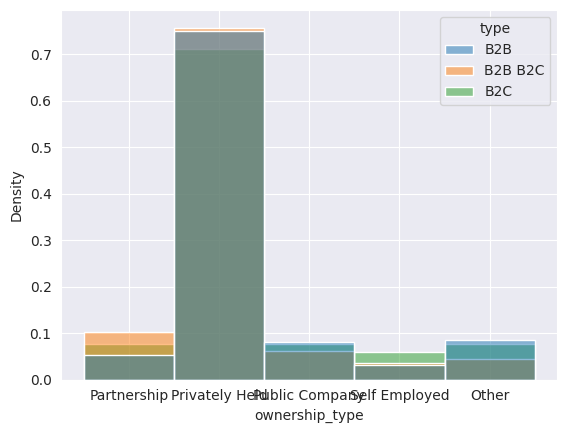

In [216]:
sns.histplot(data=df_clean, x='ownership_type', hue='type',  common_norm=False, stat="density")

## One-Hot-Encoding Categorical Variables 
---

In [200]:
df_clean.columns

Index(['employees_on_linkedin', 'followers', 'founded', 'industry',
       'ownership_type', 'size', 'specialties', 'total_funding',
       'technologies', 'categories', 'type', 'has_funding', 'has_events',
       'has_hubs', 'B2B', 'B2C'],
      dtype='object')

In [217]:
cat_cols = ['ownership_type', 'size']

In [220]:
for col in cat_cols:

  # Get one hot encoding of columns B
  one_hot = pd.get_dummies(df_clean[col])
  # Drop column B as it is now encoded
  df_clean = df_clean.drop(columns=[col],axis = 1)
  # Join the encoded df
  df_clean = df_clean.join(one_hot)

In [224]:
df_clean.head()

,employees_on_linkedin,followers,founded,industry,specialties,total_funding,technologies,categories,type,has_funding,has_events,has_hubs,B2B,B2C,Technology and Software,Marketing and Advertising,Finance and Investment,Consulting and Professional Services,Real Estate and Property,Retail and Consumer Goods,Hospitality and Tourism,Healthcare and Medical Devices,Transportation and Logistics,Education,Non-profit,Energy & Utilities,Telecommunications,Agriculture,Environmental,Legal Services,customer relationship,advertising,video sharing and streaming,website hosting,website analytics,email marketing,live chat and messaging,cloud computing,event management,payment gateways,human resource management,programming languages,e-commerce platforms,Software/IT,E-commerce,Marketing/Advertising,Consulting/Services,Human Resources,Artificial Intelligence,Social Media,Mobile/Apps,Financial Services,Retail,Education/ Learning,Real Estate,Manufacturing,Healthcare/Wellness,Transportation/Logistics,Hospitality,Market Research,Saas,Public Relations,SaaS solutions and Cloud solutions,Marketing and advertising services,Financial services and investment,IT support and cybersecurity,Recruitment and human resources,Sustainability and ethical production,Mobile applications,Artificial Intelligence and Machine Learning,Social Media Marketing and Management,Augmented and Virtual Reality,Energy Solutions (Solar Energy),Customization and Personalization,Customer Service/ExperienceSocial Media,Analytics,Educational,Government Agency,Non Profit,Nonprofit,Partnership,Privately Held,Public Company,Self Employed,Self Owned,Self-Employed,Sole Proprietorship,1-10,11-50,201-500,500+,51-200
0,-0.065928,-0.058531,0.507042,Restaurants,"saas, ERP, plateforme, restauration, grossiste...",0,NaN,NaN,B2B,0,0,0,1,0,-0.689798,-0.388719,-0.292652,-0.353711,-0.199374,-0.198774,8.464170,-0.302025,-0.259537,-0.192536,0.229334,-0.314296,-0.690340,-0.071879,-0.101073,-0.148485,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.507173,-0.308884,-0.381493,-0.462018,-0.317242,-0.330725,-0.424860,-0.441664,-0.311660,-0.331533,-0.270690,-0.207979,-0.244662,-0.251657,-0.256176,-0.305881,0.180380,-0.658030,-0.290331,1.070901,-0.181520,0.107070,0.339715,0.011011,1.062805,-0.194621,0.105379,0.085102,0.110293,0.353929,0.442179,0.564328,0.342750,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,-0.190220,-0.166734,-0.139792,Staffing and Recruiting,Cards and payments recruitment,0,"New Relic, YouTube, Eventbrite, Microsoft Offi...","Consulting, Human Resources, Insurance, Small ...",B2B,0,1,0,1,0,-0.564790,-0.281207,-0.144944,0.293283,0.345233,0.263593,0.267596,0.407160,0.166529,0.362062,1.379577,1.221955,-0.386203,0.393883,0.450745,0.772870,0,0,0,0,1,0,0,1,0,0,0,0,0,-0.497307,0.055698,-0.371482,3.503437,1.264421,-0.318656,-0.398450,-0.420346,-0.260462,-0.311558,-0.249222,-0.192646,-0.225039,-0.227859,-0.234270,-0.272874,0.336427,-0.593596,-0.249558,-0.074418,-0.206203,0.682488,0.154849,0.437983,-0.040519,0.558652,-0.155725,-0.009749,0.179423,0.545712,0.335805,-0.069470,-0.105665,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,0.045934,-0.094660,0.507042,Information Technology and Services,"assessment, recruitment, selection, hiring, HR...",150000,Amazon SES,"Artificial Intelligence, Recruiting, Human Res...",B2B,1,0,1,1,0,0.653490,-0.370045,-0.269627,-0.027635,-0.165830,-0.197895,-0.148693,0.083520,-0.144736,-0.115452,-0.112451,0.063154,0.232805,-0.071477,-0.116499,-0.084790,0,0,0,0,0,1,0,1,0,0,0,0,0,-0.497322,-0.407830,-0.373286,-0.438252,2.034764,3.233110,-0.400398,-0.426567,-0.299359,-0.310962,-0.226386,-0.196856,-0.227375,-0.231385,-0.237685,-0.262071,-0.419455,-0.572263,-0.256793,-0.361341,-0.436018,-0.308120,-0.295546,7.046277,-0.456327,-0.456576,-0.166653,-0.434454,-0.378092,-0.374003,-0.572753,-0.600212,-0.385002,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0.493383,1.820885,0.102771,Printing,"Promotional Products Supplier, Industrial Auto...",0,"HubSpot, New Relic, React, Salesforce, Sendgri...","Software Engineering, Retail Technology, Indus...",

## Feature Scaling
---

In [186]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['employees_on_linkedin', 'followers', 'founded']

# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df_clean[cols_to_scale])

# Transform the selected columns with the fitted scaler
df_clean[cols_to_scale] = scaler.transform(df_clean[cols_to_scale])

In [188]:
df_clean[cols_to_scale]

,employees_on_linkedin,followers,founded
0,-0.065928,-0.058531,0.507042
1,-0.190220,-0.166734,-0.139792
2,0.045934,-0.094660,0.507042
3,0.493383,1.820885,0.102771
4,-0.202649,-0.251645,0.102771
...,...,...,...
1794,-0.190220,-0.254396,NaN
1795,-0.065928,-0.232939,0.183625
1796,-0.184005,-0.239174,-3.778234
1797,-0.202649,-0.252745,0.264480


In [225]:
df_clean.to_csv('df_clean.csv')

## Text Features: NLP for feature extraction
---

The information contained on the ***SPECIALTIES,  CATEGORIES, INDUSTRY and TECHNOLOGIES*** columns is valuable for gaining insights on the businesses' operation/type.

By applying NLP techniques to text data, we can **create new features** that capture important aspects of the language used in texts. These features can then be **used as inputs** to machine learning algorithms, such as XGBoost, to improve their performance.

There are two stages to this process:

1) Firstly, I have used **GPT-3.5** (via the *ChatGPT* interface) as a tool for defining features to be extracted from texts:
  
  - This can be seen as a simple summarization task: by creating batches of randomly sampled texts from each of the features' corpus, I have summarized their content in 15-20 different **categories** or **characteristics**. This process has been repeated several times and throughout the whole dataset, as to avoid biases that could have been produced by different batches.

  - I could have used the free API to provide a complete pipeline of feature extraction inside this notebook, but given the time constraints for the project, I have chosen not to.

 - Note: I thoroughly believe that large language models are very useful for automating a specific set of tasks and should be considered as a valid alternative or tool to be used, with the required caution. I had tried common summarization techiniques on the texts over this specific task, by using tokenizers and word counting, but have achieved better results with the large language model. 

2) Secondly, I have used facebook's **BART** for **feature extraction** over text data:
  
  - The idea is to categorize the text over the different 'characteristics' extracted by GPT-3.5. The model returns us tensors of the probabilities of the text being adequate to each provided category. 

  - The returned probabilites are a **float point value that range from 0-1** for each of the 15-20 defined categories.  
  
  - I have chosen BART because of it's **state of the art performance** on categorization tasks over texts, and also because of the convenience of using a ready-to-deploy **pipeline()** from Huggingface Transformers over a custom set of labels.

### Imports and Configs
---

In [63]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from sklearn.feature_extraction.text import CountVectorizer

In [64]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

In [65]:
df_txt = df_clean.copy()

### specialties:
specialties provides us with valuable information on the company's industry. For the information to be useful, NLP preprocessing must be used for feature extraction, as the terms are too diverse and one-hot encoding of the categories as they are would not be feaseble

In [108]:
for spec in df_clean['specialties'].value_counts().keys():
  print(spec)

, Sales, Consulting, Leadership, Marketing, Business
Sales, Consulting, Customer Acquisition, Marketing, Business, and 
Logistics
SaaS, education, Schools, startup, edtech, and colleges, Education Reformation
Chatbot, and Marketing Digital, Atendimento automatizado
Seed Funding, Due Diligence, Mentorship, and Networking
SAAS, Venture Capital, , IT, and Software
Distribution, Sales, Purchasing, Quality Assurance, Marketing, Customer Service, Promotion, Innovation, Logistics, Results, Product Marketing, Brand Promotion, Retail Strategy, Added Value Services, Employee Incentive Programs, Inventory Balancing Control, Product Introductions/Launch, and Marketing Strategy
Social Media Marketing, Digital Marketing, Website development, Website maintenance, Online Marketing, Ecommerce Development, Search Engine Optimization [SEO], Google ad words
marketing, constru√ß√£o civil, constru√ß√£o, and marketing digital
telecommunications, hosted voip, unified communications, VoIP software, hosted pbx,

In [109]:
list_of_specialties = df.loc[df['specialties'].notnull()]['specialties'].tolist()

In [110]:
word_count = {}

irrelevant_words = ['and', 'de', 'is', '&', 'as',  ]

for row in df.loc[df['specialties'].notnull()]['specialties'].tolist():
    # Split the text into individual words
    words = row.split()
    # Loop through each word and update the count in the dictionary
    for word in words:
        if word in irrelevant_words:
            continue 
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1

# reverse dict decreasing count
word_count = dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True))

# Print the count dictionary
print(list(word_count.keys())[:600])
print(len(word_count))

['Marketing,', 'marketing,', 'Management,', 'Business', 'Sales', 'Development,', 'Digital', 'Services,', 'Marketing', ',', 'Social', 'Data', 'Mobile', 'Customer', 'marketing', 'Software,', 'Online', 'business', 'Software', 'Design,', 'Intelligence,', 'Lead', 'Technology,', 'development,', 'Management', 'software,', 'SaaS,', 'management,', 'Web', 'Email', 'sales', 'Sales,', 'Generation,', 'for', 'Analytics,', 'Research,', 'Content', 'Media', 'digital', 'customer', 'online', 'Product', 'IT', 'lead', 'to', 'Market', 'Cloud', 'data', 'b2b', 'Solutions,', 'Learning,', 'Advertising,', 'software', 'e', 'Media,', 'of', 'Artificial', 'services,', 'generation,', 'para', 'Machine', 'Strategy,', 'design,', 'email', 'Financial', 'Brand', 'content', 'mobile', 'Training,', 'Employee', '/', 'Data,', 'Service,', 'Enterprise', 'social', 'Internet', 'management', 'Consulting,', 'strategy,', 'solutions,', 'Real', 'data,', 'Corporate', 'analytics,', 'web', 'Platform,', 'Website', 'Automation,', 'Big', 'e-c

In [111]:
sample_specialty = df.loc[df['specialties'].notnull()]['specialties'].sample(n=80)
print(''.join(sample_specialty.values))

business intelligenceweb design, web development, custom web programming, branding, corporate identity, ecommerce, consulting, mobile applications, digital marketing, graphic design, brand strategy, illustrationsReal Estate, Internet, Consumer AppsSoftware and Recruitmentmartech, sales, affiliate, marketing, saas, ai, automation, white-labelMobile Technology, On Demand, Photography Technology, GigWeb design nigeria, E-commerce development, Api integration and development, Mobile data collection, Web developmentecommerce solutions, b2b ecommerce, manufafurers & distributors, and ecommerce platformSoftware, Vendas, Aplicativo MobileReal Estate, Property, Medical, Health, NDIS, SDA, Listing Platform, and InsuranceSoftware Development, FinTech, Financial Technology, Blockchain, Smart Contracts, Cryptography, Digital Identities, Instant Payments, Distributed Ledger Technology, DLT, Cross-Border Payments, Reg Tech, and Next Level Blockchain PlatformRecursos Humanos, Talentos, Recrutamento e 

In [112]:
specialty_labels = [
  'E-commerce',
  'SaaS solutions and Cloud solutions',
  'Marketing and advertising services',
  'Financial services and investment',
  'IT support and cybersecurity',
  'Market Research',
  'Recruitment and human resources',
  'Sustainability and ethical production',
  'Mobile applications',
  'Artificial Intelligence and Machine Learning',
  'Social Media Marketing and Management',
  'Augmented and Virtual Reality',
  'Energy Solutions (Solar Energy)',
  'Customization and Personalization',
  'Customer Service/Experience'
  'Social Media',
  'Analytics'
]

In [113]:
len(specialty_labels)

16

In [114]:
df_txt[specialty_labels] = 0

In [115]:
# Load pre-trained BART model
classifier = pipeline(model="facebook/bart-large-mnli", label_list=specialty_labels, device=device_id)

for index, row in tqdm(df_txt.iterrows(), total=df_txt.shape[0]):
    if pd.isna(row['specialties']):
      continue
    cat = row['specialties']
    predicted_category = classifier(cat, candidate_labels=specialty_labels,)
    for label, score in zip(predicted_category['labels'], predicted_category['scores']):
      df_txt.loc[index, label] = score

  1%|          | 10/1781 [00:04<14:05,  2.09it/s]/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 1781/1781 [10:42<00:00,  2.77it/s]


In [117]:
df_txt[specialty_labels]

,E-commerce,SaaS solutions and Cloud solutions,Marketing and advertising services,Financial services and investment,IT support and cybersecurity,Market Research,Recruitment and human resources,Sustainability and ethical production,Mobile applications,Artificial Intelligence and Machine Learning,Social Media Marketing and Management,Augmented and Virtual Reality,Energy Solutions (Solar Energy),Customization and Personalization,Customer Service/ExperienceSocial Media,Analytics
0,0.022725,0.148686,0.046047,0.044551,0.035700,0.051374,0.042514,0.113268,0.055642,0.051325,0.045087,0.027675,0.030762,0.111821,0.080136,0.092687
1,0.101111,0.032355,0.041732,0.102855,0.025997,0.063494,0.096007,0.033300,0.194787,0.022139,0.037541,0.031015,0.038033,0.100788,0.038336,0.040510
2,0.001452,0.003212,0.001558,0.002482,0.002356,0.004784,0.923925,0.003163,0.007253,0.020917,0.003754,0.004081,0.003164,0.006559,0.003332,0.008007
3,0.075540,0.014354,0.339086,0.010941,0.011991,0.028182,0.014308,0.016532,0.036873,0.020472,0.022748,0.016921,0.016149,0.328365,0.020041,0.027497
4,0.317881,0.033372,0.074596,0.045205,0.015310,0.026160,0.016564,0.096701,0.073827,0.029709,0.034046,0.029840,0.021139,0.073865,0.060330,0.051454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,0.017547,0.026390,0.491228,0.011568,0.011286,0.025962,0.020048,0.121764,0.039154,0.014762,0.034397,0.034293,0.015719,0.075365,0.040455,0.020062
1795,0.008276,0.007837,0.006833,0.869232,0.006344,0.009855,0.006501,0.008402,0.011780,0.008296,0.007823,0.008459,0.009454,0.007995,0.006513,0.016400
1796,0.034783,0.032167,0.019032,0.030563,0.033874,0.144810,0.033525,0.149027,0.060897,0.035238,0.033266,0.047113,0.037126,0.149351,0.041380,0.117847
1797,0.032386,0.032611,0.133537,0.040188,0.027966,0.078022,0.082869,0.051486,0.051437,0.026844,0.058560,0.040100,0.034931,0.141493,0.057150,0.110421


### categories:
categories also provides us with valuable information on the company's actuation sector. There are 1537 distinct values for industry, so some category grouping needs to be done

In [99]:
df_clean.categories.value_counts()

Advertising, Marketing,                                                                                                          21
Marketing,                                                                                                                       13
E-Commerce, ,                                                                                                                    13
Software,                                                                                                                        11
E-Commerce,                                                                                                                      11
                                                                                                                                 ..
Internet, Retail, E-Commerce, Home Decor, Interior Design,                                                                        1
Information Technology, Artificial Intelligence, Software, Automotive, Logis

In [100]:
print(len(df_clean['categories'].value_counts()))

for cat in df_clean['categories'].value_counts().keys()[1500:]:
  print(cat)

1520
Medical, Marketplace, E-Commerce, Supply Chain Management, , Medical Device
Consulting, Guides, Venture Capital, Blogging Platforms, Event Management,
CRM, Enterprise Software, Travel, Transaction Processing, Business Information Systems,
Information Technology, Insurance, ,
Retail, Marketplace, Retail Technology, E-Commerce, , Wholesale, Fashion, Shopping, E-Commerce Platforms
Internet, Internet of Things,
Travel, , Tourism, Transportation
Information Technology, Information Services, SaaS,
Internet of Things,
Retail, Advertising, Printing, Point of Sale,
Recruiting, , Business Intelligence
Mobile, Information Technology, Software, iOS, Enterprise Software, Crowdsourcing, Outsourcing,
Construction, Consulting, Business Intelligence, , Industrial Engineering
Software, Computer,
Recruiting,
Internet, Retail, E-Commerce, Home Decor, Interior Design,
Information Technology, Artificial Intelligence, Software, Automotive, Logistics, Internet of Things, Agriculture,
Venture Capital, Fin

In [101]:
word_count = {}

irrelevant_words = ['and', 'de', 'is', '&', 'as', ',' ]

for row in df.loc[df['categories'].notnull()]['categories'].tolist():
    # Split the text into individual words
    words = row.split()
    # Loop through each word and update the count in the dictionary
    for word in words:
        if word in irrelevant_words:
            continue 
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1

# reverse dict decreasing count
word_count = dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True))

# Print the count dictionary
print(word_count)
print(len(word_count))

{'Software,': 511, 'Information': 341, 'Technology,': 322, 'E-Commerce,': 308, 'Marketing,': 307, 'SaaS,': 248, 'Internet,': 217, 'Consulting,': 172, 'Services,': 156, 'Advertising,': 148, 'Enterprise': 137, 'Small': 131, 'Medium': 131, 'Businesses,': 131, 'Human': 128, 'Resources,': 125, 'Intelligence,': 113, 'Management,': 106, 'Apps,': 102, 'Business': 93, 'Artificial': 92, 'Social': 86, 'Mobile,': 84, 'Marketplace,': 77, 'Digital': 74, 'Mobile': 74, 'Financial': 73, 'Media,': 70, 'Development,': 68, 'Health': 66, 'Big': 61, 'Data,': 61, 'Retail,': 61, 'Machine': 59, 'of': 58, 'Education,': 58, 'Web': 56, 'FinTech,': 55, 'Internet': 52, 'Things,': 52, 'Sales,': 50, 'Design,': 49, 'Analytics,': 48, 'Care,': 47, 'Automation,': 46, 'E-Commerce': 46, 'Platforms': 46, 'Real': 44, 'Consumer': 44, 'Finance,': 41, 'CRM,': 41, 'Cloud': 39, 'Venture': 37, 'Capital,': 37, 'Lead': 36, 'Logistics,': 36, 'Data': 35, 'Market': 34, 'Travel,': 34, 'Learning': 33, 'Retail': 33, 'Recruiting,': 32, 'Se

In [102]:
category_labels = [
'Software/IT',
'E-commerce',
'Marketing/Advertising',
'Consulting/Services',
'Human Resources',
'Artificial Intelligence',
'Social Media',
'Mobile/Apps',
'Financial Services',
'Retail',
'Education/ Learning',
'Real Estate',
'Manufacturing',
'Healthcare/Wellness',
'Transportation/Logistics',
'Hospitality',
'Market Research',
'Saas',
'Public Relations'
]

print(len(category_labels))

19


In [103]:
df_txt[category_labels] = 0

In [104]:
# Load pre-trained BART model
classifier = pipeline(model="facebook/bart-large-mnli", label_list=category_labels, device=device_id)

for index, row in tqdm(df_txt.iterrows(), total=df_txt.shape[0]):
    if pd.isna(row['categories']):
      continue
    cat = row['categories']
    predicted_category = classifier(cat, candidate_labels=category_labels,)
    for label, score in zip(predicted_category['labels'], predicted_category['scores']):
      df_txt.loc[index, label] = score

  1%|          | 11/1781 [00:05<15:51,  1.86it/s]/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 1781/1781 [16:02<00:00,  1.85it/s]


In [106]:
df_txt[category_labels+['type']]

,Software/IT,E-commerce,Marketing/Advertising,Consulting/Services,Human Resources,Artificial Intelligence,Social Media,Mobile/Apps,Financial Services,Retail,Education/ Learning,Real Estate,Manufacturing,Healthcare/Wellness,Transportation/Logistics,Hospitality,Market Research,Saas,Public Relations,type
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,B2B
1,0.001982,0.001839,0.001922,0.687978,0.258624,0.001916,0.003487,0.003355,0.007906,0.001824,0.001666,0.001402,0.001517,0.002650,0.001874,0.002069,0.005615,0.009231,0.003143,B2B
2,0.001979,0.001143,0.001576,0.004123,0.384585,0.565721,0.003230,0.002376,0.001900,0.001878,0.003438,0.001017,0.001337,0.002258,0.001582,0.002746,0.004239,0.012288,0.002585,B2B
3,0.157027,0.023646,0.007996,0.015948,0.009799,0.027661,0.016789,0.031706,0.008350,0.544780,0.009379,0.008480,0.028942,0.011430,0.013083,0.009662,0.012674,0.054574,0.008074,B2B B2C
4,0.020481,0.008836,0.008916,0.024808,0.010995,0.011043,0.712385,0.037928,0.007681,0.008980,0.017418,0.006064,0.006909,0.010201,0.008700,0.012088,0.011454,0.053175,0.021939,B2C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,0.003541,0.003901,0.003246,0.014946,0.002911,0.002372,0.002901,0.005068,0.908409,0.004149,0.002304,0.003020,0.002883,0.002849,0.003254,0.002821,0.004870,0.023748,0.002807,B2B
1795,0.180598,0.006456,0.005834,0.667718,0.006366,0.006455,0.009647,0.009266,0.005428,0.005129,0.004736,0.003974,0.005104,0.006360,0.005455,0.005800,0.033869,0.025362,0.006443,B2B
1796,0.036559,0.022766,0.024445,0.099980,0.046158,0.026378,0.033858,0.037863,0.043588,0.030157,0.024311,0.064801,0.058719,0.053589,0.059312,0.062068,0.037045,0.204951,0.033451,B2B
1797,0.006941,0.010608,0.007281,0.013875,0.005700,0.007269,0.070278,0.177423,0.008377,0.017186,0.005942,0.600316,0.003641,0.005861,0.005876,0.007825,0.012834,0.026201,0.006568,B2B


### industry:
industry provides us with valuable information on the company's actuation sector. There are only 114 distinct values for industry, thus we will try to one-hot encode these categories without more complex feature engineering on the first attempt

In [76]:
df_clean.industry.value_counts()

Information Technology and Services     314
Internet                                254
Computer Software                       203
Marketing and Advertising               189
Financial Services                       61
                                       ... 
Maritime                                  1
Non-Profit Organization Management        1
Alternative Dispute Resolution            1
Mining & Metals                           1
Recreational Facilities and Services      1
Name: industry, Length: 114, dtype: int64

In [77]:
for ind in df_clean['industry'].value_counts().keys():
  print(ind)

Information Technology and Services
Internet
Computer Software
Marketing and Advertising
Financial Services
Venture Capital & Private Equity
Management Consulting
Information Services
Human Resources
Market Research
Staffing and Recruiting
Real Estate
Logistics and Supply Chain
Retail
Health, Wellness and Fitness
Public Relations and Communications
Telecommunications
Information Technology & Services
Business Supplies and Equipment
Events Services
Design
Leisure, Travel & Tourism
Consumer Services
Professional Training & Coaching
Food & Beverages
Wholesale
Apparel & Fashion
Automotive
Publishing
Consumer Goods
Accounting
E-Learning
International Trade and Development
Investment Management
Entertainment
Online Media
Insurance
Media Production
Farming
Consumer Electronics
Education Management
Translation and Localization
Electrical/Electronic Manufacturing
Facilities Services
Legal Services
Research
Program Development
Renewables & Environment
Hospitality
Printing
Medical Devices
Biotech

In [78]:
industry_labels = [
  'Technology and Software',
  'Marketing and Advertising',
  'Finance and Investment', 
  'Consulting and Professional Services',
  'Real Estate and Property',
  'Retail and Consumer Goods',
  'Hospitality and Tourism',
  'Healthcare and Medical Devices',
  'Transportation and Logistics',
  'Education',
  'Non-profit',
  'Energy & Utilities',
  'Telecommunications',
  'Agriculture',
  'Environmental',
  'Legal Services'
] 

In [79]:
len(industry_labels)

16

In [80]:
df_txt[industry_labels] = 0

In [81]:
df_clean['industry']

0                               Restaurants
1                   Staffing and Recruiting
2       Information Technology and Services
3                                  Printing
4                      Information Services
                       ...                 
1794                       Executive Office
1795                  Management Consulting
1796                    Facilities Services
1797                            Real Estate
1798                              Insurance
Name: industry, Length: 1781, dtype: object

In [82]:
# Load pre-trained BART model
classifier = pipeline(model="facebook/bart-large-mnli", label_list=industry_labels, device=device_id)

for index, row in tqdm(df_txt.iterrows(), total=df_txt.shape[0]):
    if pd.isna(row['industry']):
      continue
    ind = row['industry']
    predicted_category = classifier(ind, candidate_labels=industry_labels,)
    for label, score in zip(predicted_category['labels'], predicted_category['scores']):
      df_txt.loc[index, label] = score

  1%|          | 10/1781 [00:07<14:24,  2.05it/s]/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 1781/1781 [13:20<00:00,  2.23it/s]


In [84]:
df_txt[industry_labels]

,Technology and Software,Marketing and Advertising,Finance and Investment,Consulting and Professional Services,Real Estate and Property,Retail and Consumer Goods,Hospitality and Tourism,Healthcare and Medical Devices,Transportation and Logistics,Education,Non-profit,Energy & Utilities,Telecommunications,Agriculture,Environmental,Legal Services
0,0.010621,0.013688,0.011821,0.018029,0.013290,0.019970,0.766112,0.011190,0.012472,0.010990,0.040678,0.014308,0.015523,0.013813,0.015129,0.012367
1,0.048097,0.044037,0.038840,0.094051,0.058559,0.073008,0.050637,0.061579,0.053914,0.060545,0.089615,0.067229,0.098499,0.045269,0.051062,0.065060
2,0.413317,0.018959,0.016033,0.056343,0.016078,0.020071,0.014299,0.038584,0.023638,0.017878,0.026137,0.027310,0.267379,0.013840,0.014125,0.016009
3,0.051140,0.072406,0.046989,0.096518,0.072226,0.058098,0.062119,0.063893,0.066039,0.050020,0.068099,0.069093,0.069258,0.035671,0.057525,0.060906
4,0.242842,0.033785,0.030354,0.069282,0.031801,0.024547,0.021174,0.036068,0.033124,0.053352,0.041247,0.032552,0.304518,0.017586,0.016581,0.011186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,0.073423,0.062357,0.069995,0.112649,0.073279,0.041570,0.049796,0.043046,0.058858,0.046969,0.067891,0.071688,0.066320,0.037107,0.045046,0.080007
1795,0.022603,0.033228,0.025817,0.632232,0.037265,0.021879,0.020141,0.024802,0.029591,0.015479,0.032994,0.028863,0.022405,0.014968,0.018983,0.018751
1796,0.047001,0.034518,0.036814,0.068146,0.048644,0.033323,0.101487,0.090625,0.068754,0.038784,0.056080,0.189325,0.099439,0.027577,0.035741,0.023742
1797,0.009126,0.018384,0.014190,0.022646,0.792264,0.017486,0.010365,0.011109,0.010978,0.010736,0.024408,0.011991,0.012434,0.011523,0.010465,0.011896


### Technologies:

In [85]:
df_clean.technologies.value_counts()

YouTube                                                                                                                      44
Google AdWords                                                                                                               41
HubSpot                                                                                                                      26
LinkedIn Ads                                                                                                                 22
Tawk.to                                                                                                                      17
                                                                                                                             ..
HubSpot, Pardot, Salesforce, YouTube, Salesforce Pardot, Eventbrite, Drift                                                    1
YouTube, Nodejs, Expressjs                                                                              

In [86]:
print(len(df_clean['technologies'].value_counts()))
print('Consider the following stack of technologies. Sum up their uses with 15 different categories:')
for tech in df_clean['technologies'].value_counts().keys()[500:750]:
  print(tech)

735
Consider the following stack of technologies. Sum up their uses with 15 different categories:
SAP Hybris Commerce Cloud, Java, New Relic, SAP, YouTube, SAP Commerce Cloud, Microsoft Office 365
HubSpot, Next.js, Salesforce, LinkedIn Ads, Google AdWords, Zendesk
Amazon Cloudfront, Amazon Web Services, HubSpot, YouTube, Hubspot Form Builder
YouTube, Drift
HubSpot, Unbounce, WooCommerce, WordPress, YouTube, Amazon Route 53, LinkedIn Ads, Google AdWords
YouTube,  Wave Financial, LinkedIn Ads, Google AdWords, Zendesk
Amazon Cloudfront, Amazon Web Services, HubSpot, Intercom, MailChimp, New Relic, Optimizely, Outbrain, WordPress, YouTube, Hubspot Form Builder, Sendgrid, Amazon Route 53, Google AdWords, Zendesk
Amazon Cloudfront, Amazon Web Services, Drupal, HubSpot, WordPress, YouTube, Hubspot Form Builder, Amazon Route 53, LinkedIn Ads, Google AdWords
Google Cloud, HubSpot, Google Cloud DNS, Microsoft Azure, LinkedIn Ads
HubSpot, Next.js, YouTube, Hubspot CMS, Hubspot Form Builder, Zende

In [87]:
word_count = {}

irrelevant_words = ['and', 'de', 'is', '&', 'as', ',' ]

for row in df.loc[df['technologies'].notnull()]['technologies'].tolist():
    # Split the text into individual words
    words = row.split(',')
    # Loop through each word and update the count in the dictionary
    for word in words:
        if word in irrelevant_words:
            continue 
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1

# reverse dict decreasing count
word_count = dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True))

# Print the count dictionary
print(word_count.keys())
print(len(word_count))

dict_keys([' Google AdWords', ' LinkedIn Ads', 'HubSpot', ' YouTube', ' Amazon Route 53', ' Zendesk', ' Hubspot Form Builder', ' New Relic', ' Sendgrid', 'YouTube', ' WordPress', ' Unbounce', 'Amazon Cloudfront', ' Salesforce', ' Microsoft Office 365', ' HubSpot', ' MailChimp', ' Zendesk Support', ' Mailgun', 'New Relic', ' Amazon SES', ' Amazon Web Services', 'Google AdWords', ' Google Cloud DNS', 'Amazon Web Services', 'Intercom', 'MailChimp', 'Google Cloud', ' Drift', ' Intercom', 'LinkedIn Ads', ' Tawk.to', 'Tawk.to', ' Next.js', ' Expressjs', 'Google AdSense', ' Nodejs', ' Salesforce Pardot', ' Stripe', ' Java', ' Mixpanel', 'Drupal', ' Marketo', 'Amazon S3', ' Segment', ' Zendesk JavaScript API', ' React', ' Zendesk Chat', ' Pardot', ' Eventbrite', ' Hubspot CMS', ' Marketo Email', ' Microsoft ASP.NET', ' WooCommerce', 'Next.js', 'Microsoft ASP.NET', ' Vuejs', ' Tidio', 'LiveChat', 'Angular', ' AngularJS', 'Salesforce', ' Microsoft Azure', ' Drupal', 'Nodejs', ' LiveChat', ' Goog

In [88]:
tech_stack_dict = {
  "Google AdWords": ["advertising"],
  "LinkedIn Ads": ["advertising"],
  "HubSpot": ["customer relationship", "email marketing", "website analytics", "event management"],
  "YouTube": ["video sharing and streaming"],
  "Amazon Route 53": ["cloud computing", "website hosting"],
  "Zendesk": ["customer relationship", "live chat and messaging"],
  "Hubspot Form Builder": ["customer relationship", "email marketing"],
  "New Relic": ["cloud computing", "website analytics"],
  "Sendgrid": ["email marketing"],
  "WordPress": ["website hosting", "e-commerce platforms"],
  "Unbounce": ["website analytics", "advertising"],
  "Amazon Cloudfront": ["cloud computing", "website hosting"],
  "Salesforce": ["customer relationship", "human resource management"],
  "Microsoft Office 365": ["cloud computing", "human resource management"],
  "MailChimp": ["email marketing"],
  "Zendesk Support": ["customer relationship", "live chat and messaging"],
  "Mailgun": ["email marketing"],
  "Amazon SES": ["email marketing", "cloud computing"],
  "Amazon Web Services": ["cloud computing"],
  "Google Cloud DNS": ["cloud computing"],
  "Intercom": ["customer relationship", "live chat and messaging"],
  "Tawk.to": ["customer relationship", "live chat and messaging"],
  "Next.js": ["programming languages", "website hosting"],
  "Expressjs": ["programming languages"],
  "Google AdSense": ["advertising"],
  "Nodejs": ["programming languages"],
  "Salesforce Pardot": ["email marketing", "customer relationship"],
  "Stripe": ["payment gateways"],
  "Java": ["programming languages"],
  "Mixpanel": ["website analytics"],
  "Drupal": ["website hosting", "e-commerce platforms"],
  "Marketo": ["email marketing", "customer relationship", "event management"],
  "Amazon S3": ["cloud computing", "website hosting"],
  "Segment": ["website analytics"],
  "Zendesk JavaScript API": ["customer relationship", "live chat and messaging"],
  "React": ["programming languages"],
  "Zendesk Chat": ["customer relationship", "live chat and messaging"],
  "Pardot": ["email marketing", "customer relationship"],
  "Eventbrite": ["event management"],
  "Hubspot CMS": ["e-commerce platforms", "website hosting"],
  "Marketo Email": ["email marketing", "customer relationship", "event management"],
  "Microsoft ASP.NET": ["programming languages", "cloud computing"],
  "WooCommerce": ["e-commerce platforms"],
  "Vuejs": ["programming languages"]
}

In [148]:
tech_labels = ['customer relationship',
'advertising' ,
'video sharing and streaming',
'website hosting',
'website analytics',
'email marketing',
'live chat and messaging',
'cloud computing',
'event management',
'payment gateways',
'human resource management',
'programming languages',
'e-commerce platforms']

In [89]:
df_txt[tech_labels] = 0

In [90]:
for index, row in df_txt.iterrows():
    if pd.isna(row['technologies']):
      continue
    techs = row['technologies'].split(',')
    for tech in techs:
        if tech in tech_stack_dict.keys():
          for cat in tech_stack_dict[tech]:
            df_txt.loc[index, cat] = 1



In [95]:
df_txt[tech_labels]

,customer relationship,advertising,video sharing and streaming,website hosting,website analytics,email marketing,live chat and messaging,cloud computing,event management,payment gateways,human resource management,programming languages,e-commerce platforms
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,1,0,0,0,0,0
3,1,0,0,0,1,1,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,0,0,0,0,0,0,0,0,0,0,0,0,0
1795,0,0,0,0,0,0,0,0,0,0,0,0,0
1796,0,0,0,0,0,0,0,0,0,0,0,0,0
1797,0,0,1,0,0,0,0,0,0,0,0,0,0


In [228]:
df_txt.to_csv('df_txt.csv')

### Text Feature Scaling
---

MIN MAX SCALER??????????????

In [190]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = category_labels + industry_labels + specialty_labels

# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df_txt[cols_to_scale])

# Transform the selected columns with the fitted scaler
df_txt[cols_to_scale] = scaler.transform(df_txt[cols_to_scale])

0 mean and 1 std!

In [193]:
df_txt[cols_to_scale].describe()

,Software/IT,E-commerce,Marketing/Advertising,Consulting/Services,Human Resources,Artificial Intelligence,Social Media,Mobile/Apps,Financial Services,Retail,Education/ Learning,Real Estate,Manufacturing,Healthcare/Wellness,Transportation/Logistics,Hospitality,Market Research,Saas,Public Relations,Technology and Software,Marketing and Advertising,Finance and Investment,Consulting and Professional Services,Real Estate and Property,Retail and Consumer Goods,Hospitality and Tourism,Healthcare and Medical Devices,Transportation and Logistics,Education,Non-profit,Energy & Utilities,Telecommunications,Agriculture,Environmental,Legal Services,E-commerce,SaaS solutions and Cloud solutions,Marketing and advertising services,Financial services and investment,IT support and cybersecurity,Market Research,Recruitment and human resources,Sustainability and ethical production,Mobile applications,Artificial Intelligence and Machine Learning,Social Media Marketing and Management,Augmented and Virtual Reality,Energy Solutions (Solar Energy),Customization and Personalization,Customer Service/ExperienceSocial Media,Analytics
count,1.781000e+03,1.781000e+03,1.781000e+03,1781.000000,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1781.000000,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03
mean,-2.393743e-17,3.291397e-17,-5.984358e-18,0.000000,-2.692961e-17,-2.194264e-17,-1.595829e-17,-3.839963e-17,-3.989572e-18,-2.194264e-17,-9.973929e-18,-1.196872e-17,1.994786e-18,-1.396350e-17,1.196872e-17,1.196872e-17,4.388529e-17,-5.984358e-18,-2.393743e-17,-8.577579e-17,2.194264e-17,1.296611e-17,2.094525e-17,-4.986965e-18,-1.695568e-17,-1.994786e-17,2.244134e-17,2.194264e-17,0.000000,-7.979144e-18,-3.490875e-17,-3.989572e-18,-1.994786e-18,-1.994786e-17,-2.194264e-17,3.291397e-17,-4.986965e-17,-2.393743e-17,2.792700e-17,-4.986965e-18,4.388529e-17,4.986965e-18,3.191657e-17,-1.944916e-17,1.396350e-17,-1.994786e-18,-2.194264e-17,9.973929e-18,-4.488268e-17,9.973929e-19,-3.590615e-17
std,1.000281e+00,1.000281e+00,1.000281e+00,1.000281,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00,1.000281e+00
min,-5.071731e-01,-4.145818e-01,-3.814933e-01,-0.462018,-3.172422e-01,-3.307252e-01,-4.248596e-01,-4.416643e-01,-3.116605e-01,-3.315328e-01,-2.706899e-01,-2.079792e-01,-2.446622e-01,-2.516573e-01,-2.561759e-01,-3.058809e-01,-4.810521e-01,-6.580305e-01,-2.903311e-01,-7.252286e-01,-4.372078e-01,-3.572742e-01,-5.071491e-01,-3.592507e-01,-3.728704e-01,-3.125020e-01,-4.595218e-01,-3.877595e-01,-0.315537,-7.267787e-01,-7.296365e-01,-7.472366e-01,-2.763993e-01,-3.334092e-01,-3.647195e-01,-4.145818e-01,-3.929618e-01,-4.449278e-01,-3.326173e-01,-3.404400e-01,-4.810521e-01,-3.283295e-01,-4.999691e-01,-4.958423e-01,-3.537817e-01,-4.816362e-01,-4.625727e-01,-4.574724e-01,-6.359992e-01,-6.507313e-01,-4.538157e-01
25%,-4.867084e-01,-4.145818e-01,-3.653476e-01,-0.427260,-3.018586e-01,-3.081779e-01,-3.806228e-01,-3.885771e-01,-2.928497e-01,-2.936079e-01,-2.375067e-

### Visualize Feature Distribution
---

In [191]:
len(category_labels)

19

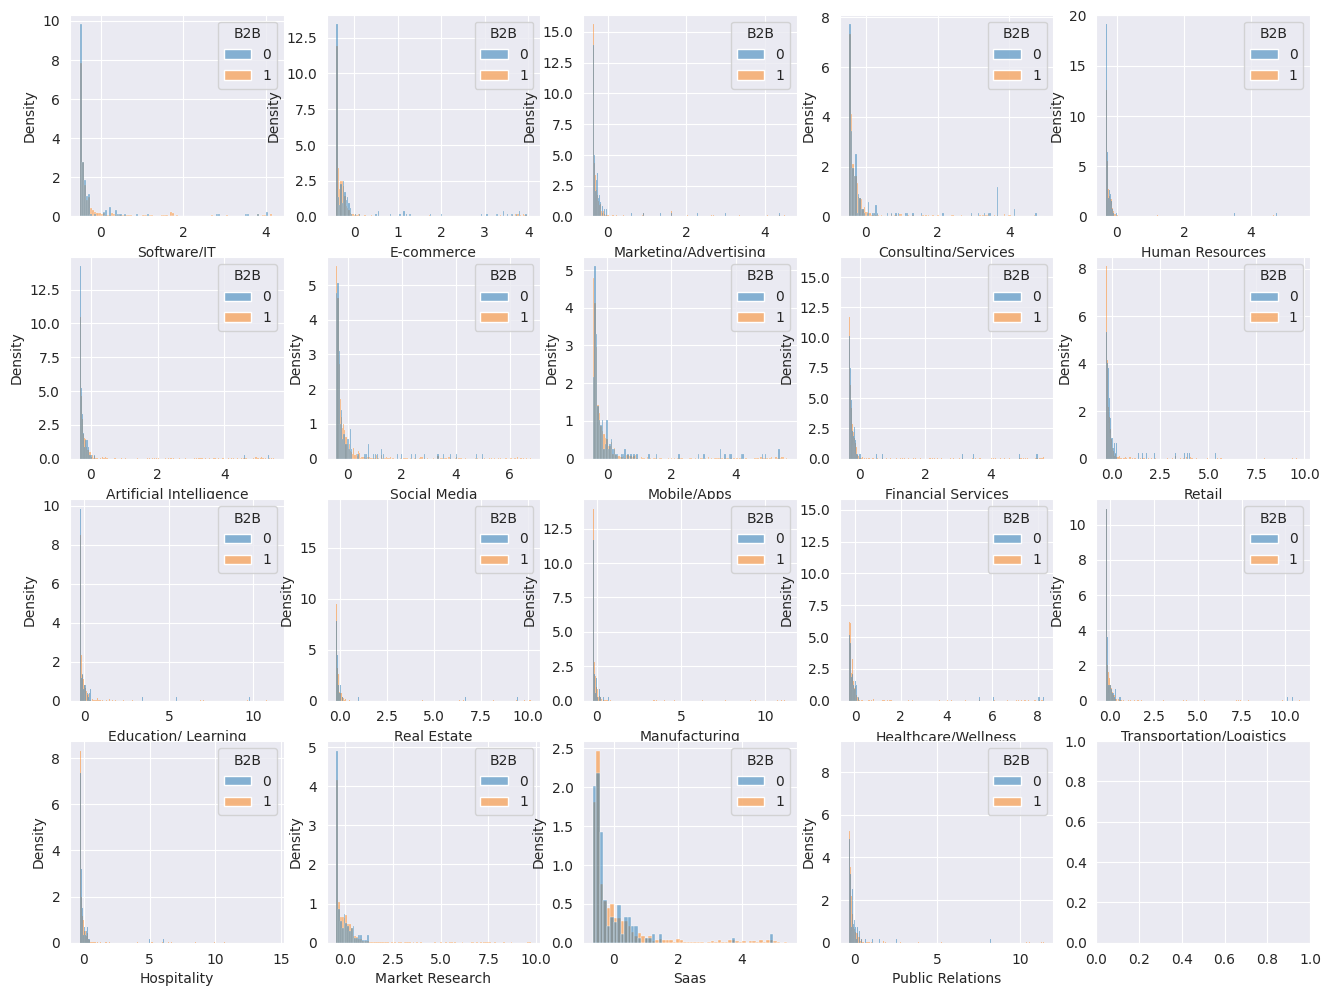

In [194]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 16))
axes = axes.flatten()

for i, feat in enumerate(category_labels):
  a = sns.histplot(data=df_txt, x=feat, hue='B2B', ax=axes[i], common_norm=False, stat="density")
  plt.setp(ax.get_xticklabels(), rotation=70,  horizontalalignment='right')
  plt.gcf().subplots_adjust(bottom=0.3)

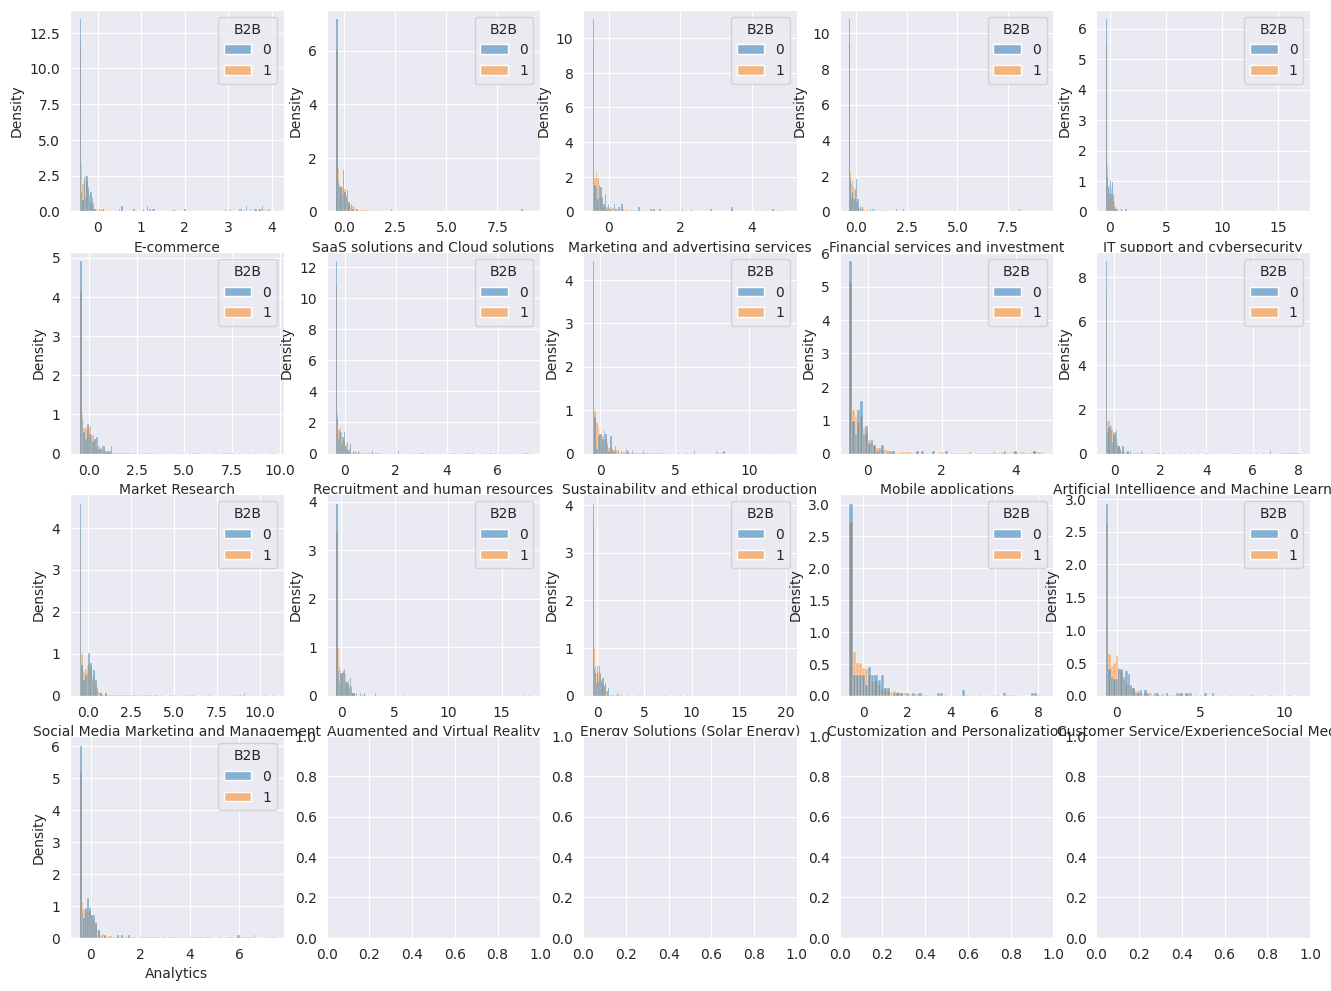

In [195]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 16))
axes = axes.flatten()

for i, feat in enumerate(specialty_labels):
  a = sns.histplot(data=df_txt, x=feat, hue='B2B', ax=axes[i], common_norm=False, stat="density")
  plt.setp(ax.get_xticklabels(), rotation=70,  horizontalalignment='right')
  plt.gcf().subplots_adjust(bottom=0.3)

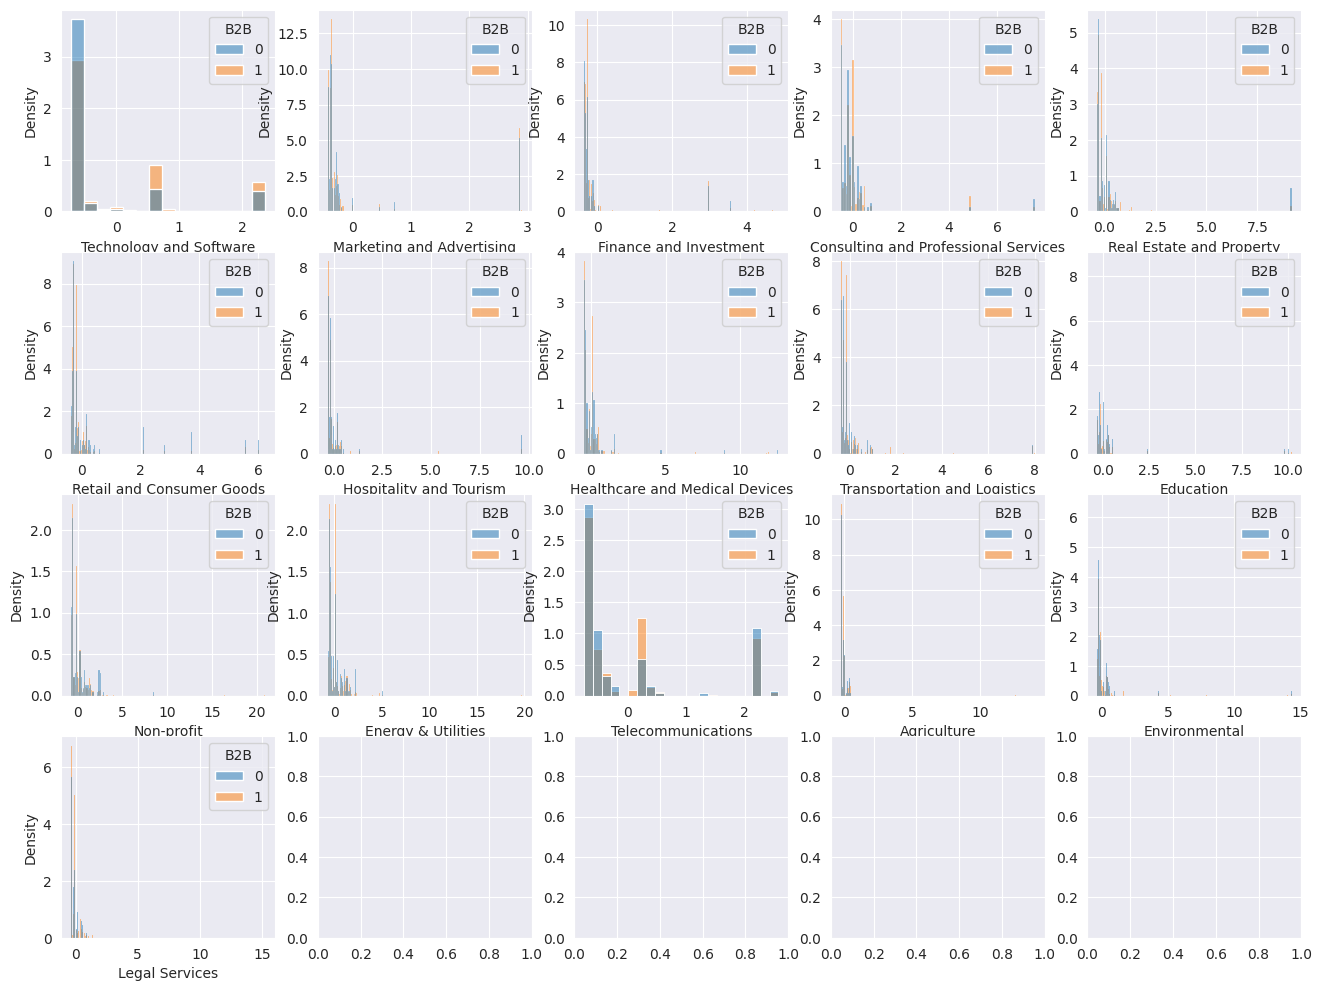

In [196]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 16))
axes = axes.flatten()

for i, feat in enumerate(industry_labels):
  a = sns.histplot(data=df_txt, x=feat, hue='B2B', ax=axes[i], common_norm=False, stat="density")
  plt.setp(ax.get_xticklabels(), rotation=70,  horizontalalignment='right')
  plt.gcf().subplots_adjust(bottom=0.3)

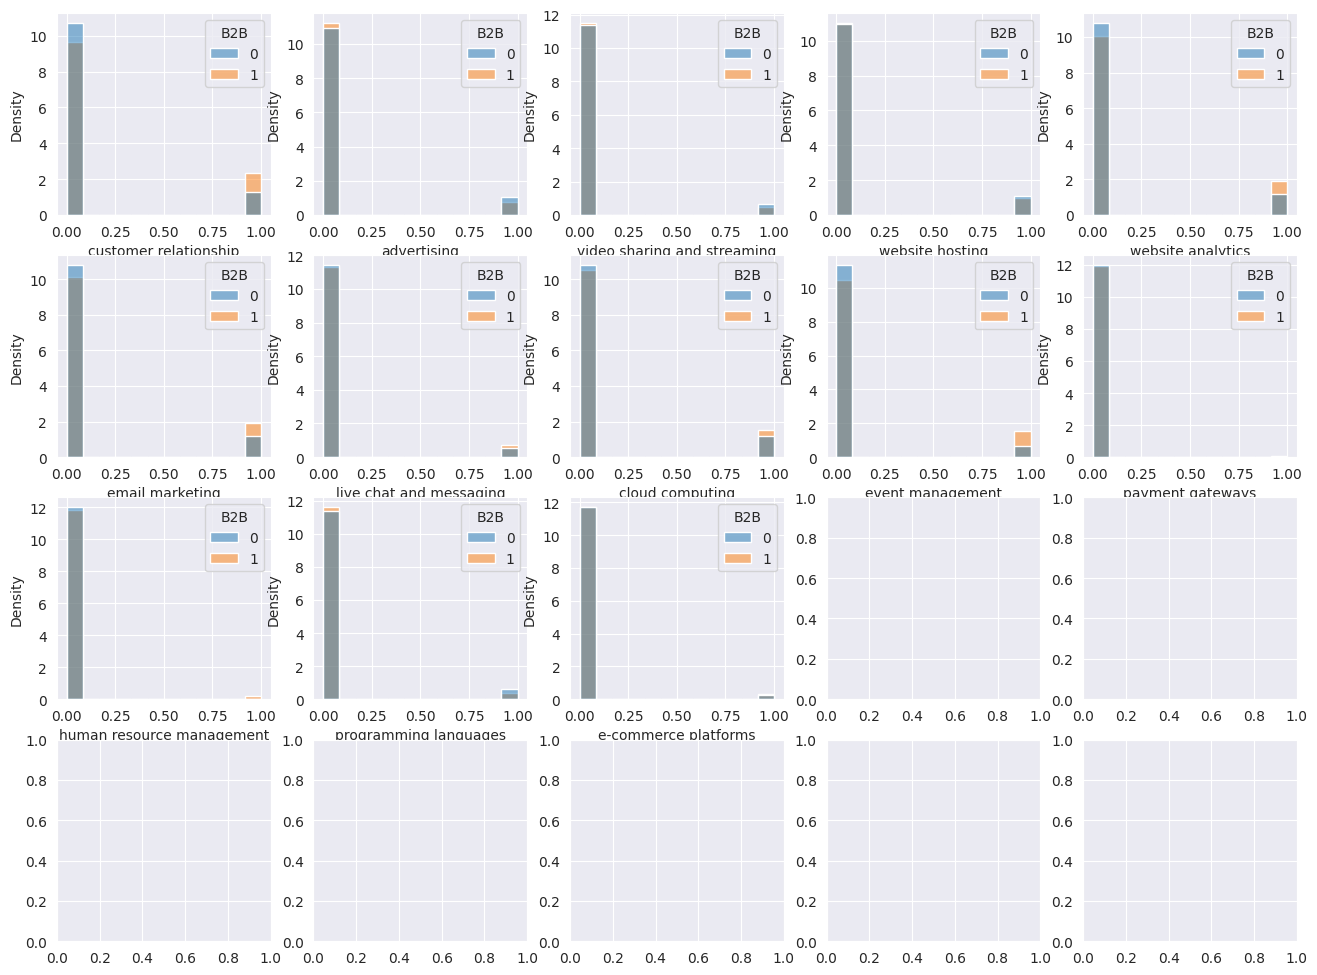

In [197]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 16))
axes = axes.flatten()

for i, feat in enumerate(tech_labels):
  a = sns.histplot(data=df_txt, x=feat, hue='B2B', ax=axes[i], common_norm=False, stat="density")
  plt.setp(ax.get_xticklabels(), rotation=70,  horizontalalignment='right')
  plt.gcf().subplots_adjust(bottom=0.3)

In [229]:
df_txt.to_csv('df_txt_scaled.csv')

# Model Training
---

In [226]:
df_txt.head()

,employees_on_linkedin,followers,founded,industry,specialties,total_funding,technologies,categories,type,has_funding,has_events,has_hubs,B2B,B2C,Technology and Software,Marketing and Advertising,Finance and Investment,Consulting and Professional Services,Real Estate and Property,Retail and Consumer Goods,Hospitality and Tourism,Healthcare and Medical Devices,Transportation and Logistics,Education,Non-profit,Energy & Utilities,Telecommunications,Agriculture,Environmental,Legal Services,customer relationship,advertising,video sharing and streaming,website hosting,website analytics,email marketing,live chat and messaging,cloud computing,event management,payment gateways,human resource management,programming languages,e-commerce platforms,Software/IT,E-commerce,Marketing/Advertising,Consulting/Services,Human Resources,Artificial Intelligence,Social Media,Mobile/Apps,Financial Services,Retail,Education/ Learning,Real Estate,Manufacturing,Healthcare/Wellness,Transportation/Logistics,Hospitality,Market Research,Saas,Public Relations,SaaS solutions and Cloud solutions,Marketing and advertising services,Financial services and investment,IT support and cybersecurity,Recruitment and human resources,Sustainability and ethical production,Mobile applications,Artificial Intelligence and Machine Learning,Social Media Marketing and Management,Augmented and Virtual Reality,Energy Solutions (Solar Energy),Customization and Personalization,Customer Service/ExperienceSocial Media,Analytics,Educational,Government Agency,Non Profit,Nonprofit,Partnership,Privately Held,Public Company,Self Employed,Self Owned,Self-Employed,Sole Proprietorship,1-10,11-50,201-500,500+,51-200
0,-0.065928,-0.058531,0.507042,Restaurants,"saas, ERP, plateforme, restauration, grossiste...",0,NaN,NaN,B2B,0,0,0,1,0,-0.689798,-0.388719,-0.292652,-0.353711,-0.199374,-0.198774,8.464170,-0.302025,-0.259537,-0.192536,0.229334,-0.314296,-0.690340,-0.071879,-0.101073,-0.148485,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.507173,-0.308884,-0.381493,-0.462018,-0.317242,-0.330725,-0.424860,-0.441664,-0.311660,-0.331533,-0.270690,-0.207979,-0.244662,-0.251657,-0.256176,-0.305881,0.180380,-0.658030,-0.290331,1.070901,-0.181520,0.107070,0.339715,0.011011,1.062805,-0.194621,0.105379,0.085102,0.110293,0.353929,0.442179,0.564328,0.342750,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,-0.190220,-0.166734,-0.139792,Staffing and Recruiting,Cards and payments recruitment,0,"New Relic, YouTube, Eventbrite, Microsoft Offi...","Consulting, Human Resources, Insurance, Small ...",B2B,0,1,0,1,0,-0.564790,-0.281207,-0.144944,0.293283,0.345233,0.263593,0.267596,0.407160,0.166529,0.362062,1.379577,1.221955,-0.386203,0.393883,0.450745,0.772870,0,0,0,0,1,0,0,1,0,0,0,0,0,-0.497307,0.055698,-0.371482,3.503437,1.264421,-0.318656,-0.398450,-0.420346,-0.260462,-0.311558,-0.249222,-0.192646,-0.225039,-0.227859,-0.234270,-0.272874,0.336427,-0.593596,-0.249558,-0.074418,-0.206203,0.682488,0.154849,0.437983,-0.040519,0.558652,-0.155725,-0.009749,0.179423,0.545712,0.335805,-0.069470,-0.105665,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,0.045934,-0.094660,0.507042,Information Technology and Services,"assessment, recruitment, selection, hiring, HR...",150000,Amazon SES,"Artificial Intelligence, Recruiting, Human Res...",B2B,1,0,1,1,0,0.653490,-0.370045,-0.269627,-0.027635,-0.165830,-0.197895,-0.148693,0.083520,-0.144736,-0.115452,-0.112451,0.063154,0.232805,-0.071477,-0.116499,-0.084790,0,0,0,0,0,1,0,1,0,0,0,0,0,-0.497322,-0.407830,-0.373286,-0.438252,2.034764,3.233110,-0.400398,-0.426567,-0.299359,-0.310962,-0.226386,-0.196856,-0.227375,-0.231385,-0.237685,-0.262071,-0.419455,-0.572263,-0.256793,-0.361341,-0.436018,-0.308120,-0.295546,7.046277,-0.456327,-0.456576,-0.166653,-0.434454,-0.378092,-0.374003,-0.572753,-0.600212,-0.385002,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0.493383,1.820885,0.102771,Printing,"Promotional Products Supplier, Industrial Auto...",0,"HubSpot, New Relic, React, Salesforce, Sendgri...","Software Engineering, Retail Technology, Indus...",

In [227]:
df_txt.columns

Index(['employees_on_linkedin', 'followers', 'founded', 'industry',
       'specialties', 'total_funding', 'technologies', 'categories', 'type',
       'has_funding', 'has_events', 'has_hubs', 'B2B', 'B2C',
       'Technology and Software', 'Marketing and Advertising',
       'Finance and Investment', 'Consulting and Professional Services',
       'Real Estate and Property', 'Retail and Consumer Goods',
       'Hospitality and Tourism', 'Healthcare and Medical Devices',
       'Transportation and Logistics', 'Education', 'Non-profit',
       'Energy & Utilities', 'Telecommunications', 'Agriculture',
       'Environmental', 'Legal Services', 'customer relationship',
       'advertising', 'video sharing and streaming', 'website hosting',
       'website analytics', 'email marketing', 'live chat and messaging',
       'cloud computing', 'event management', 'payment gateways',
       'human resource management', 'programming languages',
       'e-commerce platforms', 'Software/IT', 'E-comm

In [248]:
# df_train = df_txt.drop(columns=['ownership_type', 'size'])
df_train = df_txt.drop(columns=['specialties', 'total_funding', 'technologies', 'categories', 'specialties', 'industry']).copy()

In [237]:
df_train.shape

(1781, 87)

### Get X & y

In [305]:
X = df_train.drop(columns=['B2C', 'B2B', 'type']).copy()
X_b2c = df_train.drop(columns=['B2C', 'B2B', 'type']).copy()
X_b2b = df_train.drop(columns=['B2C', 'B2B', 'type']).copy()

y = df_train[['B2B', 'B2C']]
y_b2c = y['B2C']
y_b2b = y['B2B']

In [308]:
y_b2c.value_counts()

0    1299
1     482
Name: B2C, dtype: int64

In [309]:
y_b2b.value_counts()

1    1612
0     169
Name: B2B, dtype: int64

### Undersampling
---

After frustrated attempts to fit the model (that was mostly just predicting one class, B2B), I have decided to undersample the dataset to better fit the two tasks.

In [310]:
from imblearn.under_sampling import RandomUnderSampler

In [311]:
rus = RandomUnderSampler(random_state=42)
X_b2c_resampled, y_b2c_resampled = rus.fit_resample(X_b2c, y_b2c)

In [329]:
rus = RandomUnderSampler(random_state=42)
X_b2b_resampled, y_b2b_resampled = rus.fit_resample(X_b2b, y_b2b)

In [313]:
y_b2c_resampled.value_counts()

0    482
1    482
Name: B2C, dtype: int64

In [314]:
y_b2b_resampled.value_counts()

0    169
1    169
Name: B2B, dtype: int64

### Train_test_split

In [267]:
from sklearn.model_selection import train_test_split

# split the dataframe into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print the shapes of the resulting sets
print("Training set shape: X_train = {}, y_train = {}".format(X_train.shape, y_train.shape))
print("Testing set shape: X_test = {}, y_test = {}".format(X_test.shape, y_test.shape))

y_train_b2c = y_train['B2C'].to_list()
y_train_b2b = y_train['B2B'].to_list()

y_test_b2c = y_test['B2C'].to_list()
y_test_b2b = y_test['B2B']

Training set shape: X_train = (1424, 84), y_train = (1424, 2)
Testing set shape: X_test = (357, 84), y_test = (357, 2)


In [330]:
from sklearn.model_selection import train_test_split

# split the dataframe into training and testing sets
X_train_b2c, X_test_b2c, y_train_b2c, y_test_b2c = train_test_split(X_b2c_resampled, y_b2c_resampled, test_size=0.2, random_state=42)

# print the shapes of the resulting sets
print("Training set shape: X_train = {}, y_train = {}".format(X_train_b2c.shape, y_train_b2c.shape))
print("Testing set shape: X_test = {}, y_test = {}".format(X_test_b2c.shape, y_test_b2c.shape))

Training set shape: X_train = (771, 84), y_train = (771,)
Testing set shape: X_test = (193, 84), y_test = (193,)


In [331]:
from sklearn.model_selection import train_test_split

# split the dataframe into training and testing sets
X_train_b2b, X_test_b2b, y_train_b2b, y_test_b2b = train_test_split(X_b2b_resampled, y_b2b_resampled, test_size=0.2, random_state=42)

# print the shapes of the resulting sets
print("Training set shape: X_train = {}, y_train = {}".format(X_train_b2b.shape, y_train_b2b.shape))
print("Testing set shape: X_test = {}, y_test = {}".format(X_test_b2b.shape, y_test_b2b.shape))

Training set shape: X_train = (270, 84), y_train = (270,)
Testing set shape: X_test = (68, 84), y_test = (68,)


In [321]:
y_train_b2c.value_counts()

0    396
1    375
Name: B2C, dtype: int64

In [322]:
y_train_b2b.value_counts()

1    139
0    131
Name: B2B, dtype: int64

## Model Selection
---

In [323]:
import lightgbm as lgb
from optuna.samplers import TPESampler
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## B2C MODEL

### LightGBM

In [326]:
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "num_iterations": trial.suggest_int("num_iterations", 100, 1000),
        "random_state": 42
    }
    
    # Train and evaluate the model
    model = lgb.train(params, lgb.Dataset(X_train_b2c, label=y_train_b2c), valid_sets=[lgb.Dataset(X_test_b2c, label=y_test_b2c)], verbose_eval=False)
    y_pred = model.predict(X_test_b2c)

    accuracy = accuracy_score(y_test_b2c, [1 if p>0.5 else 0 for p in y_pred])
    return accuracy

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and accuracy score
print("Best hyperparameters: ", study.best_params)
print("Best accuracy score: ", study.best_value)

b2c_lgb_best_params = study.best_params

[I 2023-04-03 07:23:51,993] A new study created in memory with name: no-name-94330ee7-3656-40d9-8fa4-2c13892a6801
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:23:52,146] Trial 0 finished with value: 0.6632124352331606 and parameters: {'lambda_l1': 5.692243362181446, 'lambda_l2': 1.6228850836391286, 'num_leaves': 86, 'learning_rate': 0.1605222843970104, 'feature_fraction': 0.35981825757417807, 'bagging_fraction': 0.19387872048462967, 'bagging_freq': 1, 'min_chil

[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=56


[I 2023-04-03 07:23:52,374] Trial 1 finished with value: 0.6735751295336787 and parameters: {'lambda_l1': 2.9720881329689584, 'lambda_l2': 6.351196716490492, 'num_leaves': 13, 'learning_rate': 0.34376437673383314, 'feature_fraction': 0.7315209315841371, 'bagging_fraction': 0.7269405995330284, 'bagging_freq': 4, 'min_child_samples': 51, 'min_data_in_leaf': 56, 'max_depth': 13, 'num_iterations': 903}. Best is trial 1 with value: 0.6735751295336787.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=7


[I 2023-04-03 07:23:52,609] Trial 4 finished with value: 0.6010362694300518 and parameters: {'lambda_l1': 7.16150288375379, 'lambda_l2': 7.421717343222555, 'num_leaves': 209, 'learning_rate': 0.29732554543039075, 'feature_fraction': 0.7763641572399895, 'bagging_fraction': 0.8180330286773231, 'bagging_freq': 3, 'min_child_samples': 44, 'min_data_in_leaf': 7, 'max_depth': 4, 'num_iterations': 203}. Best is trial 1 with value: 0.6735751295336787.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of L

[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=68


[I 2023-04-03 07:23:52,857] Trial 7 finished with value: 0.6269430051813472 and parameters: {'lambda_l1': 1.400025226217491, 'lambda_l2': 3.1273252456527656, 'num_leaves': 225, 'learning_rate': 0.013674741368122677, 'feature_fraction': 0.28172539276070935, 'bagging_fraction': 0.7557445938480997, 'bagging_freq': 7, 'min_child_samples': 62, 'min_data_in_leaf': 68, 'max_depth': 11, 'num_iterations': 108}. Best is trial 1 with value: 0.6735751295336787.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=51


[I 2023-04-03 07:23:53,524] Trial 10 finished with value: 0.6735751295336787 and parameters: {'lambda_l1': 0.2757669266106295, 'lambda_l2': 9.974656983887499, 'num_leaves': 5, 'learning_rate': 0.4273281208558114, 'feature_fraction': 0.9969235791708233, 'bagging_fraction': 0.9521377506493598, 'bagging_freq': 3, 'min_child_samples': 83, 'min_data_in_leaf': 51, 'max_depth': 14, 'num_iterations': 978}. Best is trial 1 with value: 0.6735751295336787.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=54


[I 2023-04-03 07:23:53,786] Trial 11 finished with value: 0.6373056994818653 and parameters: {'lambda_l1': 0.13804222589975634, 'lambda_l2': 9.937207806071678, 'num_leaves': 2, 'learning_rate': 0.42832691187639066, 'feature_fraction': 0.9717051234442071, 'bagging_fraction': 0.9239694102731552, 'bagging_freq': 3, 'min_child_samples': 86, 'min_data_in_leaf': 54, 'max_depth': 14, 'num_iterations': 967}. Best is trial 1 with value: 0.6735751295336787.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=48


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=99 will be ignored. Current value: min_data_in_leaf=62


[I 2023-04-03 07:23:54,405] Trial 13 finished with value: 0.6528497409326425 and parameters: {'lambda_l1': 0.01972333534212467, 'lambda_l2': 5.873348149103269, 'num_leaves': 50, 'learning_rate': 0.5495984707373414, 'feature_fraction': 0.864804231032049, 'bagging_fraction': 0.7227026108802388, 'bagging_freq': 5, 'min_child_samples': 99, 'min_data_in_leaf': 62, 'max_depth': 11, 'num_iterations': 806}. Best is trial 1 with value: 0.6735751295336787.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=40


[I 2023-04-03 07:23:54,832] Trial 15 finished with value: 0.6683937823834197 and parameters: {'lambda_l1': 3.3654157127319437, 'lambda_l2': 6.645930867119065, 'num_leaves': 44, 'learning_rate': 0.2566020761440124, 'feature_fraction': 0.9033064783304926, 'bagging_fraction': 0.8520245457126022, 'bagging_freq': 2, 'min_child_samples': 77, 'min_data_in_leaf': 76, 'max_depth': 10, 'num_iterations': 640}. Best is trial 1 with value: 0.6735751295336787.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=76


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:23:55,078] Trial 16 finished with value: 0.6113989637305699 and parameters: {'lambda_l1': 1.290869855314689, 'lambda_l2': 4.753522457296698, 'num_leaves': 146, 'learning_rate': 0.4916478825017241, 'feature_fraction': 0.7398820985579453, 'bagging_fraction': 0.650800180977858, 'bagging_freq': 5, 'min_child_samples': 6, 'min_data_in_leaf': 55, 'max_depth': 19, 'num_iterations': 885}. Best is trial 1 with value: 0.673575

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=55


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:23:55,257] Trial 17 finished with value: 0.616580310880829 and parameters: {'lambda_l1': 2.1010867255612844, 'lambda_l2': 8.508971916538805, 'num_leaves': 29, 'learning_rate': 0.6280806023873593, 'feature_fraction': 0.8636616768112888, 'bagging_fraction': 0.8629826893559858, 'bagging_freq': 2, 'min_child_samples': 65, 'min_data_in_leaf': 36, 'max_depth': 3, 'num_iterations': 618}. Best is trial 1 with value: 0.673575

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=66


[I 2023-04-03 07:23:55,611] Trial 18 finished with value: 0.6373056994818653 and parameters: {'lambda_l1': 0.6904747945970235, 'lambda_l2': 7.052316738074811, 'num_leaves': 85, 'learning_rate': 0.37740668865949617, 'feature_fraction': 0.5647020381885816, 'bagging_fraction': 0.7003706994884624, 'bagging_freq': 4, 'min_child_samples': 84, 'min_data_in_leaf': 66, 'max_depth': 8, 'num_iterations': 882}. Best is trial 1 with value: 0.6735751295336787.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=44


[I 2023-04-03 07:23:55,895] Trial 19 finished with value: 0.6321243523316062 and parameters: {'lambda_l1': 2.3863280129770876, 'lambda_l2': 9.15735566260568, 'num_leaves': 86, 'learning_rate': 0.21841193576964033, 'feature_fraction': 0.9706748396875416, 'bagging_fraction': 0.7886951538023492, 'bagging_freq': 3, 'min_child_samples': 54, 'min_data_in_leaf': 44, 'max_depth': 13, 'num_iterations': 677}. Best is trial 1 with value: 0.6735751295336787.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=45


[I 2023-04-03 07:23:56,261] Trial 21 finished with value: 0.6787564766839378 and parameters: {'lambda_l1': 3.6333859357995806, 'lambda_l2': 9.863796980496973, 'num_leaves': 8, 'learning_rate': 0.4148480829380404, 'feature_fraction': 0.8805847086074754, 'bagging_fraction': 0.9766478662337098, 'bagging_freq': 3, 'min_child_samples': 75, 'min_data_in_leaf': 45, 'max_depth': 17, 'num_iterations': 987}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=74 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=73


[I 2023-04-03 07:23:56,716] Trial 23 finished with value: 0.6217616580310881 and parameters: {'lambda_l1': 2.5925635066835633, 'lambda_l2': 9.08382836883131, 'num_leaves': 68, 'learning_rate': 0.41549941307856686, 'feature_fraction': 0.717159729540922, 'bagging_fraction': 0.8944235238265823, 'bagging_freq': 2, 'min_child_samples': 90, 'min_data_in_leaf': 73, 'max_depth': 17, 'num_iterations': 821}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=48


[I 2023-04-03 07:23:57,089] Trial 24 finished with value: 0.6321243523316062 and parameters: {'lambda_l1': 1.08323452898346, 'lambda_l2': 7.918576098430451, 'num_leaves': 13, 'learning_rate': 0.3346282178069925, 'feature_fraction': 0.8909674343992896, 'bagging_fraction': 0.7836918905650129, 'bagging_freq': 4, 'min_child_samples': 59, 'min_data_in_leaf': 48, 'max_depth': 22, 'num_iterations': 987}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=33


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=52


[I 2023-04-03 07:23:57,605] Trial 26 finished with value: 0.6580310880829016 and parameters: {'lambda_l1': 3.9753133566345182, 'lambda_l2': 8.693461798858815, 'num_leaves': 117, 'learning_rate': 0.1695041727718899, 'feature_fraction': 0.9219182389111868, 'bagging_fraction': 0.8351429927772188, 'bagging_freq': 3, 'min_child_samples': 82, 'min_data_in_leaf': 52, 'max_depth': 18, 'num_iterations': 828}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=45


[I 2023-04-03 07:23:57,964] Trial 27 finished with value: 0.6217616580310881 and parameters: {'lambda_l1': 0.7460403846990054, 'lambda_l2': 9.980997399629441, 'num_leaves': 35, 'learning_rate': 0.4047779141746931, 'feature_fraction': 0.8416098365847551, 'bagging_fraction': 0.6760674553349019, 'bagging_freq': 5, 'min_child_samples': 92, 'min_data_in_leaf': 45, 'max_depth': 8, 'num_iterations': 727}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=31


[I 2023-04-03 07:23:58,250] Trial 28 finished with value: 0.6528497409326425 and parameters: {'lambda_l1': 1.638215708060506, 'lambda_l2': 7.755179016972817, 'num_leaves': 66, 'learning_rate': 0.2958800561097833, 'feature_fraction': 0.697183158444184, 'bagging_fraction': 0.9311132450688635, 'bagging_freq': 2, 'min_child_samples': 47, 'min_data_in_leaf': 31, 'max_depth': 16, 'num_iterations': 997}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=62


[I 2023-04-03 07:23:58,598] Trial 29 finished with value: 0.6580310880829016 and parameters: {'lambda_l1': 5.561407621547371, 'lambda_l2': 9.147597985027408, 'num_leaves': 148, 'learning_rate': 0.21418875469952012, 'feature_fraction': 0.9948980410718284, 'bagging_fraction': 0.7778049612926949, 'bagging_freq': 1, 'min_child_samples': 56, 'min_data_in_leaf': 62, 'max_depth': 21, 'num_iterations': 926}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=27


[I 2023-04-03 07:23:58,871] Trial 30 finished with value: 0.6528497409326425 and parameters: {'lambda_l1': 3.0431939722944947, 'lambda_l2': 8.424978122527644, 'num_leaves': 62, 'learning_rate': 0.09093173422774598, 'feature_fraction': 0.7597473825307507, 'bagging_fraction': 0.8490020676493264, 'bagging_freq': 6, 'min_child_samples': 69, 'min_data_in_leaf': 27, 'max_depth': 12, 'num_iterations': 274}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=49


[I 2023-04-03 07:23:59,150] Trial 31 finished with value: 0.6683937823834197 and parameters: {'lambda_l1': 3.27392970481989, 'lambda_l2': 9.915025282061531, 'num_leaves': 4, 'learning_rate': 0.4302265778713992, 'feature_fraction': 0.908662443424788, 'bagging_fraction': 0.9900651575134851, 'bagging_freq': 3, 'min_child_samples': 77, 'min_data_in_leaf': 49, 'max_depth': 17, 'num_iterations': 993}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of L

[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=43


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:23:59,601] Trial 33 finished with value: 0.6373056994818653 and parameters: {'lambda_l1': 4.228308525646622, 'lambda_l2': 8.674917934274372, 'num_leaves': 4, 'learning_rate': 0.3534378363945143, 'feature_fraction': 0.8433005080202807, 'bagging_fraction': 0.8802122950091881, 'bagging_freq': 3, 'min_child_samples': 90, 'min_data_in_leaf': 55, 'max_depth': 15, 'num_iterations': 940}. Best is trial 21 with value: 0.67875

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=55


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:23:59,756] Trial 34 finished with value: 0.6580310880829016 and parameters: {'lambda_l1': 4.579744575418641, 'lambda_l2': 9.54733284279298, 'num_leaves': 42, 'learning_rate': 0.26845611462545177, 'feature_fraction': 0.94183992801754, 'bagging_fraction': 0.953842941584233, 'bagging_freq': 3, 'min_child_samples': 65, 'min_data_in_leaf': 83, 'max_depth': 17, 'num_iterations': 478}. Best is trial 21 with value: 0.6787564

[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=40


[I 2023-04-03 07:23:59,940] Trial 35 finished with value: 0.6062176165803109 and parameters: {'lambda_l1': 3.554859623343524, 'lambda_l2': 6.891146460891032, 'num_leaves': 91, 'learning_rate': 0.5592269816108806, 'feature_fraction': 0.8800899885495137, 'bagging_fraction': 0.822191429953061, 'bagging_freq': 2, 'min_child_samples': 50, 'min_data_in_leaf': 40, 'max_depth': 25, 'num_iterations': 786}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=21


[I 2023-04-03 07:24:00,339] Trial 37 finished with value: 0.6528497409326425 and parameters: {'lambda_l1': 2.9959173813315494, 'lambda_l2': 3.702231033887223, 'num_leaves': 32, 'learning_rate': 0.307244386776074, 'feature_fraction': 0.9491372838516489, 'bagging_fraction': 0.6256967371894346, 'bagging_freq': 3, 'min_child_samples': 59, 'min_data_in_leaf': 21, 'max_depth': 30, 'num_iterations': 744}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=73


[I 2023-04-03 07:24:00,807] Trial 39 finished with value: 0.6476683937823834 and parameters: {'lambda_l1': 2.5171178014516657, 'lambda_l2': 7.433004144753152, 'num_leaves': 10, 'learning_rate': 0.5273879320706722, 'feature_fraction': 0.825497132144647, 'bagging_fraction': 0.5601029707910519, 'bagging_freq': 1, 'min_child_samples': 77, 'min_data_in_leaf': 73, 'max_depth': 13, 'num_iterations': 902}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=15


[I 2023-04-03 07:24:01,070] Trial 40 finished with value: 0.6269430051813472 and parameters: {'lambda_l1': 1.839188178613317, 'lambda_l2': 9.953153891425464, 'num_leaves': 74, 'learning_rate': 0.46094868244316545, 'feature_fraction': 0.7462165417100244, 'bagging_fraction': 0.7411875832777544, 'bagging_freq': 2, 'min_child_samples': 95, 'min_data_in_leaf': 15, 'max_depth': 11, 'num_iterations': 998}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=78


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:24:01,485] Trial 42 finished with value: 0.6528497409326425 and parameters: {'lambda_l1': 3.6078036278551635, 'lambda_l2': 5.193718906946588, 'num_leaves': 20, 'learning_rate': 0.24144246398679048, 'feature_fraction': 0.9454011736097918, 'bagging_fraction': 0.8129219992629864, 'bagging_freq': 3, 'min_child_samples': 71, 'min_data_in_leaf': 88, 'max_depth': 6, 'num_iterations': 366}. Best is trial 21 with value: 0.678

[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=95


[I 2023-04-03 07:24:01,726] Trial 43 finished with value: 0.6217616580310881 and parameters: {'lambda_l1': 2.8186732899917586, 'lambda_l2': 6.581740948033329, 'num_leaves': 42, 'learning_rate': 0.384872693108999, 'feature_fraction': 0.8932701478788316, 'bagging_fraction': 0.945855151328904, 'bagging_freq': 2, 'min_child_samples': 88, 'min_data_in_leaf': 95, 'max_depth': 14, 'num_iterations': 941}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=39


[I 2023-04-03 07:24:02,133] Trial 45 finished with value: 0.6424870466321243 and parameters: {'lambda_l1': 1.5563925625711517, 'lambda_l2': 8.774443482247852, 'num_leaves': 25, 'learning_rate': 0.34416499085951957, 'feature_fraction': 0.8527905169932625, 'bagging_fraction': 0.9775373799056134, 'bagging_freq': 1, 'min_child_samples': 81, 'min_data_in_leaf': 39, 'max_depth': 16, 'num_iterations': 597}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=58


[I 2023-04-03 07:24:02,620] Trial 47 finished with value: 0.6528497409326425 and parameters: {'lambda_l1': 2.127906215406985, 'lambda_l2': 7.63176572928532, 'num_leaves': 100, 'learning_rate': 0.24217972664101925, 'feature_fraction': 0.9552419910424688, 'bagging_fraction': 0.8635797143926288, 'bagging_freq': 4, 'min_child_samples': 97, 'min_data_in_leaf': 58, 'max_depth': 18, 'num_iterations': 769}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=100


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=73


[I 2023-04-03 07:24:03,288] Trial 49 finished with value: 0.6528497409326425 and parameters: {'lambda_l1': 2.681991610253881, 'lambda_l2': 8.16955904461446, 'num_leaves': 28, 'learning_rate': 0.11452375672459048, 'feature_fraction': 0.9136876206498535, 'bagging_fraction': 0.8012589802457151, 'bagging_freq': 5, 'min_child_samples': 76, 'min_data_in_leaf': 73, 'max_depth': 20, 'num_iterations': 872}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=47


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:24:03,756] Trial 51 finished with value: 0.6528497409326425 and parameters: {'lambda_l1': 3.2639417623347637, 'lambda_l2': 9.666231122487734, 'num_leaves': 7, 'learning_rate': 0.44851182072920637, 'feature_fraction': 0.9118515453839627, 'bagging_fraction': 0.972632165850219, 'bagging_freq': 3, 'min_child_samples': 79, 'min_data_in_leaf': 52, 'max_depth': 16, 'num_iterations': 971}. Best is trial 21 with value: 0.6787

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=52


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:24:03,969] Trial 52 finished with value: 0.6528497409326425 and parameters: {'lambda_l1': 3.885659000186461, 'lambda_l2': 9.943929140439288, 'num_leaves': 2, 'learning_rate': 0.5172819044881934, 'feature_fraction': 0.9672211107297648, 'bagging_fraction': 0.9990018299672544, 'bagging_freq': 3, 'min_child_samples': 73, 'min_data_in_leaf': 49, 'max_depth': 18, 'num_iterations': 911}. Best is trial 21 with value: 0.67875

[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=49


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:24:04,215] Trial 53 finished with value: 0.6632124352331606 and parameters: {'lambda_l1': 3.276719992854294, 'lambda_l2': 8.729966174249704, 'num_leaves': 13, 'learning_rate': 0.37526489350198355, 'feature_fraction': 0.8633222079097477, 'bagging_fraction': 0.9440161801372227, 'bagging_freq': 3, 'min_child_samples': 84, 'min_data_in_leaf': 42, 'max_depth': 15, 'num_iterations': 999}. Best is trial 21 with value: 0.678

[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=42


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=35


[I 2023-04-03 07:24:04,494] Trial 54 finished with value: 0.6735751295336787 and parameters: {'lambda_l1': 2.37455962802907, 'lambda_l2': 9.339256101211202, 'num_leaves': 174, 'learning_rate': 0.4213077884228132, 'feature_fraction': 0.8213811576005158, 'bagging_fraction': 0.8677358961830236, 'bagging_freq': 2, 'min_child_samples': 59, 'min_data_in_leaf': 35, 'max_depth': 14, 'num_iterations': 849}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=31


[I 2023-04-03 07:24:04,851] Trial 55 finished with value: 0.6787564766839378 and parameters: {'lambda_l1': 0.9969913184980239, 'lambda_l2': 9.36163465942183, 'num_leaves': 174, 'learning_rate': 0.32747725508256353, 'feature_fraction': 0.8132655560209021, 'bagging_fraction': 0.8434981122390369, 'bagging_freq': 2, 'min_child_samples': 60, 'min_data_in_leaf': 31, 'max_depth': 12, 'num_iterations': 808}. Best is trial 21 with value: 0.6787564766839378.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=34


[I 2023-04-03 07:24:05,135] Trial 56 finished with value: 0.694300518134715 and parameters: {'lambda_l1': 1.0537642908632407, 'lambda_l2': 9.234165160724446, 'num_leaves': 179, 'learning_rate': 0.47522002865500557, 'feature_fraction': 0.727798281572903, 'bagging_fraction': 0.8310451226446401, 'bagging_freq': 2, 'min_child_samples': 60, 'min_data_in_leaf': 34, 'max_depth': 12, 'num_iterations': 809}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=30


[I 2023-04-03 07:24:05,466] Trial 57 finished with value: 0.6373056994818653 and parameters: {'lambda_l1': 1.167002860874322, 'lambda_l2': 9.2278495280685, 'num_leaves': 177, 'learning_rate': 0.48882622445865265, 'feature_fraction': 0.7312621411258186, 'bagging_fraction': 0.7583687565481634, 'bagging_freq': 1, 'min_child_samples': 46, 'min_data_in_leaf': 30, 'max_depth': 12, 'num_iterations': 793}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=39


[I 2023-04-03 07:24:05,963] Trial 58 finished with value: 0.6424870466321243 and parameters: {'lambda_l1': 0.23950807409938224, 'lambda_l2': 8.4755752374519, 'num_leaves': 200, 'learning_rate': 0.33375129003305265, 'feature_fraction': 0.7029498323747605, 'bagging_fraction': 0.8315107747034324, 'bagging_freq': 2, 'min_child_samples': 53, 'min_data_in_leaf': 39, 'max_depth': 13, 'num_iterations': 816}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=24


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:24:06,478] Trial 60 finished with value: 0.6787564766839378 and parameters: {'lambda_l1': 1.3440349526556319, 'lambda_l2': 9.566523857407118, 'num_leaves': 129, 'learning_rate': 0.6265415255301503, 'feature_fraction': 0.7966825462114848, 'bagging_fraction': 0.7641157020401772, 'bagging_freq': 2, 'min_child_samples': 62, 'min_data_in_leaf': 15, 'max_depth': 9, 'num_iterations': 896}. Best is trial 56 with value: 0.694

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=15


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:24:06,743] Trial 61 finished with value: 0.6321243523316062 and parameters: {'lambda_l1': 1.3690512258285252, 'lambda_l2': 9.56884402430676, 'num_leaves': 129, 'learning_rate': 0.6299534013718205, 'feature_fraction': 0.8002995192874431, 'bagging_fraction': 0.7834968700098996, 'bagging_freq': 2, 'min_child_samples': 56, 'min_data_in_leaf': 5, 'max_depth': 9, 'num_iterations': 898}. Best is trial 56 with value: 0.69430

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=5


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=11


[I 2023-04-03 07:24:07,689] Trial 62 finished with value: 0.6476683937823834 and parameters: {'lambda_l1': 0.031608491822684326, 'lambda_l2': 9.174847800036869, 'num_leaves': 220, 'learning_rate': 0.5438369719057772, 'feature_fraction': 0.7661395317846321, 'bagging_fraction': 0.8259097084736499, 'bagging_freq': 1, 'min_child_samples': 61, 'min_data_in_leaf': 11, 'max_depth': 7, 'num_iterations': 961}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=20


[I 2023-04-03 07:24:08,034] Trial 63 finished with value: 0.6632124352331606 and parameters: {'lambda_l1': 1.1374843709914688, 'lambda_l2': 9.66067556655335, 'num_leaves': 186, 'learning_rate': 0.39647879018297816, 'feature_fraction': 0.7190092729523483, 'bagging_fraction': 0.7483537655752585, 'bagging_freq': 2, 'min_child_samples': 50, 'min_data_in_leaf': 20, 'max_depth': 12, 'num_iterations': 882}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=45


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=16


[I 2023-04-03 07:24:08,695] Trial 65 finished with value: 0.6683937823834197 and parameters: {'lambda_l1': 0.6082642659518644, 'lambda_l2': 8.405938747171296, 'num_leaves': 244, 'learning_rate': 0.35295412924389175, 'feature_fraction': 0.863072633118824, 'bagging_fraction': 0.6969472149462754, 'bagging_freq': 5, 'min_child_samples': 43, 'min_data_in_leaf': 16, 'max_depth': 15, 'num_iterations': 827}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=30


[I 2023-04-03 07:24:08,998] Trial 66 finished with value: 0.6373056994818653 and parameters: {'lambda_l1': 0.970668397734255, 'lambda_l2': 9.731098405904788, 'num_leaves': 190, 'learning_rate': 0.42318189949120755, 'feature_fraction': 0.7514972743716476, 'bagging_fraction': 0.9220826158677001, 'bagging_freq': 3, 'min_child_samples': 57, 'min_data_in_leaf': 30, 'max_depth': 19, 'num_iterations': 967}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=35


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=36


[I 2023-04-03 07:24:09,506] Trial 68 finished with value: 0.6735751295336787 and parameters: {'lambda_l1': 1.507276201458959, 'lambda_l2': 8.920705232747444, 'num_leaves': 131, 'learning_rate': 0.31658662405088367, 'feature_fraction': 0.7841596159270798, 'bagging_fraction': 0.8780946747824192, 'bagging_freq': 6, 'min_child_samples': 38, 'min_data_in_leaf': 36, 'max_depth': 11, 'num_iterations': 754}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=33


[I 2023-04-03 07:24:09,785] Trial 69 finished with value: 0.616580310880829 and parameters: {'lambda_l1': 2.0226199947006034, 'lambda_l2': 7.799179334769957, 'num_leaves': 164, 'learning_rate': 0.2766768337691439, 'feature_fraction': 0.6654128099024144, 'bagging_fraction': 0.8404975884362268, 'bagging_freq': 7, 'min_child_samples': 49, 'min_data_in_leaf': 33, 'max_depth': 10, 'num_iterations': 842}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=54


[I 2023-04-03 07:24:10,075] Trial 70 finished with value: 0.689119170984456 and parameters: {'lambda_l1': 0.9255680316174961, 'lambda_l2': 8.156933361858878, 'num_leaves': 137, 'learning_rate': 0.36966984470232167, 'feature_fraction': 0.8879388750125004, 'bagging_fraction': 0.9655687287585604, 'bagging_freq': 5, 'min_child_samples': 52, 'min_data_in_leaf': 54, 'max_depth': 13, 'num_iterations': 867}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=56


[I 2023-04-03 07:24:10,389] Trial 71 finished with value: 0.6632124352331606 and parameters: {'lambda_l1': 0.9243152344151477, 'lambda_l2': 9.300018062868796, 'num_leaves': 141, 'learning_rate': 0.3176917541552844, 'feature_fraction': 0.8854296395878732, 'bagging_fraction': 0.9639804760127049, 'bagging_freq': 6, 'min_child_samples': 54, 'min_data_in_leaf': 56, 'max_depth': 13, 'num_iterations': 781}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=27


[I 2023-04-03 07:24:10,812] Trial 72 finished with value: 0.6787564766839378 and parameters: {'lambda_l1': 0.30272378907710784, 'lambda_l2': 8.584963930577754, 'num_leaves': 141, 'learning_rate': 0.3679884459799888, 'feature_fraction': 0.8156838296851279, 'bagging_fraction': 0.9603636887634583, 'bagging_freq': 7, 'min_child_samples': 44, 'min_data_in_leaf': 27, 'max_depth': 8, 'num_iterations': 869}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=26


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=28


[I 2023-04-03 07:24:11,423] Trial 74 finished with value: 0.6373056994818653 and parameters: {'lambda_l1': 0.4530046667202172, 'lambda_l2': 8.487918118678046, 'num_leaves': 117, 'learning_rate': 0.35534862659124783, 'feature_fraction': 0.8452842831728102, 'bagging_fraction': 0.9205385718809405, 'bagging_freq': 7, 'min_child_samples': 52, 'min_data_in_leaf': 28, 'max_depth': 4, 'num_iterations': 855}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=23


[I 2023-04-03 07:24:11,707] Trial 75 finished with value: 0.6424870466321243 and parameters: {'lambda_l1': 1.832618441136749, 'lambda_l2': 8.93501054371855, 'num_leaves': 138, 'learning_rate': 0.29823687389052683, 'feature_fraction': 0.7992141370109568, 'bagging_fraction': 0.7984256691263077, 'bagging_freq': 7, 'min_child_samples': 48, 'min_data_in_leaf': 23, 'max_depth': 6, 'num_iterations': 867}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=12


[I 2023-04-03 07:24:11,986] Trial 76 finished with value: 0.6321243523316062 and parameters: {'lambda_l1': 0.9390799043979281, 'lambda_l2': 8.696083298374415, 'num_leaves': 157, 'learning_rate': 0.39743829426920974, 'feature_fraction': 0.7387867729893941, 'bagging_fraction': 0.9554743704197005, 'bagging_freq': 7, 'min_child_samples': 44, 'min_data_in_leaf': 12, 'max_depth': 8, 'num_iterations': 736}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=18


[I 2023-04-03 07:24:12,497] Trial 77 finished with value: 0.6683937823834197 and parameters: {'lambda_l1': 0.35118479052102125, 'lambda_l2': 8.18376439968195, 'num_leaves': 104, 'learning_rate': 0.28008713290747544, 'feature_fraction': 0.8395842600496336, 'bagging_fraction': 0.8792668838848047, 'bagging_freq': 6, 'min_child_samples': 62, 'min_data_in_leaf': 18, 'max_depth': 7, 'num_iterations': 921}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=37


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:24:13,027] Trial 79 finished with value: 0.6373056994818653 and parameters: {'lambda_l1': 2.290936303079336, 'lambda_l2': 9.444293112166845, 'num_leaves': 125, 'learning_rate': 0.33332351079812284, 'feature_fraction': 0.8872304741294859, 'bagging_fraction': 0.8540622673989431, 'bagging_freq': 7, 'min_child_samples': 45, 'min_data_in_leaf': 34, 'max_depth': 10, 'num_iterations': 805}. Best is trial 56 with value: 0.69

[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=34


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=41


[I 2023-04-03 07:24:13,362] Trial 80 finished with value: 0.6321243523316062 and parameters: {'lambda_l1': 0.7175280824291876, 'lambda_l2': 7.8459412526593555, 'num_leaves': 151, 'learning_rate': 0.36516765786276423, 'feature_fraction': 0.7599025117215257, 'bagging_fraction': 0.8097454288122141, 'bagging_freq': 5, 'min_child_samples': 51, 'min_data_in_leaf': 41, 'max_depth': 11, 'num_iterations': 701}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=52


[I 2023-04-03 07:24:13,937] Trial 82 finished with value: 0.6632124352331606 and parameters: {'lambda_l1': 0.4764918706530621, 'lambda_l2': 9.490308072755349, 'num_leaves': 200, 'learning_rate': 0.40793797333987564, 'feature_fraction': 0.9187605181252952, 'bagging_fraction': 0.9788274317547043, 'bagging_freq': 6, 'min_child_samples': 55, 'min_data_in_leaf': 52, 'max_depth': 9, 'num_iterations': 939}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=62


[I 2023-04-03 07:24:14,265] Trial 83 finished with value: 0.6683937823834197 and parameters: {'lambda_l1': 1.7248858844316595, 'lambda_l2': 8.715534653539327, 'num_leaves': 213, 'learning_rate': 0.3878698817948801, 'feature_fraction': 0.9340023538186853, 'bagging_fraction': 0.9138706667672298, 'bagging_freq': 1, 'min_child_samples': 60, 'min_data_in_leaf': 62, 'max_depth': 13, 'num_iterations': 833}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=32


[I 2023-04-03 07:24:14,586] Trial 84 finished with value: 0.6580310880829016 and parameters: {'lambda_l1': 0.88010473590498, 'lambda_l2': 9.96257093999342, 'num_leaves': 161, 'learning_rate': 0.34144816699926406, 'feature_fraction': 0.8155515653140482, 'bagging_fraction': 0.9542647964195163, 'bagging_freq': 4, 'min_child_samples': 64, 'min_data_in_leaf': 32, 'max_depth': 14, 'num_iterations': 905}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=60


[I 2023-04-03 07:24:15,103] Trial 85 finished with value: 0.6632124352331606 and parameters: {'lambda_l1': 0.2553905740307218, 'lambda_l2': 9.129867971933136, 'num_leaves': 122, 'learning_rate': 0.4466633377289182, 'feature_fraction': 0.9666965179584674, 'bagging_fraction': 0.8879516619909721, 'bagging_freq': 6, 'min_child_samples': 67, 'min_data_in_leaf': 60, 'max_depth': 16, 'num_iterations': 952}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=28


[I 2023-04-03 07:24:15,511] Trial 86 finished with value: 0.6373056994818653 and parameters: {'lambda_l1': 0.6200339603379861, 'lambda_l2': 8.32589190387004, 'num_leaves': 138, 'learning_rate': 0.30062197306025396, 'feature_fraction': 0.9795914788986725, 'bagging_fraction': 0.9344044815024461, 'bagging_freq': 7, 'min_child_samples': 57, 'min_data_in_leaf': 28, 'max_depth': 11, 'num_iterations': 764}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=54


[I 2023-04-03 07:24:15,862] Trial 87 finished with value: 0.694300518134715 and parameters: {'lambda_l1': 1.5416750386200133, 'lambda_l2': 9.700059130598683, 'num_leaves': 101, 'learning_rate': 0.25162937150276476, 'feature_fraction': 0.8920415767664622, 'bagging_fraction': 0.9862310746623288, 'bagging_freq': 2, 'min_child_samples': 39, 'min_data_in_leaf': 54, 'max_depth': 13, 'num_iterations': 974}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=43


[I 2023-04-03 07:24:16,142] Trial 88 finished with value: 0.6476683937823834 and parameters: {'lambda_l1': 2.036884371886639, 'lambda_l2': 8.60852072278114, 'num_leaves': 108, 'learning_rate': 0.22021328396328116, 'feature_fraction': 0.8415352829506201, 'bagging_fraction': 0.9743552931653403, 'bagging_freq': 2, 'min_child_samples': 38, 'min_data_in_leaf': 43, 'max_depth': 7, 'num_iterations': 866}. Best is trial 56 with value: 0.694300518134715.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=54


[I 2023-04-03 07:24:16,494] Trial 89 finished with value: 0.7046632124352331 and parameters: {'lambda_l1': 1.2546134858632152, 'lambda_l2': 8.94174400468634, 'num_leaves': 93, 'learning_rate': 0.26473017399851717, 'feature_fraction': 0.88980554394093, 'bagging_fraction': 0.9985920223577998, 'bagging_freq': 2, 'min_child_samples': 47, 'min_data_in_leaf': 54, 'max_depth': 12, 'num_iterations': 980}. Best is trial 89 with value: 0.7046632124352331.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=55


[I 2023-04-03 07:24:16,863] Trial 90 finished with value: 0.6476683937823834 and parameters: {'lambda_l1': 1.519676842685591, 'lambda_l2': 8.964452672826924, 'num_leaves': 97, 'learning_rate': 0.248396480689263, 'feature_fraction': 0.875357360469456, 'bagging_fraction': 0.9811037491123465, 'bagging_freq': 2, 'min_child_samples': 32, 'min_data_in_leaf': 55, 'max_depth': 12, 'num_iterations': 979}. Best is trial 89 with value: 0.7046632124352331.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of 

[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=57


[I 2023-04-03 07:24:17,223] Trial 91 finished with value: 0.6683937823834197 and parameters: {'lambda_l1': 1.1173787124407775, 'lambda_l2': 9.404969066940085, 'num_leaves': 143, 'learning_rate': 0.2663922989299272, 'feature_fraction': 0.8950516183239408, 'bagging_fraction': 0.9949022458113601, 'bagging_freq': 2, 'min_child_samples': 46, 'min_data_in_leaf': 57, 'max_depth': 12, 'num_iterations': 921}. Best is trial 89 with value: 0.7046632124352331.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=53


[I 2023-04-03 07:24:17,547] Trial 92 finished with value: 0.6373056994818653 and parameters: {'lambda_l1': 1.8421142683252891, 'lambda_l2': 9.661265906739386, 'num_leaves': 77, 'learning_rate': 0.3284216558366849, 'feature_fraction': 0.8494892812103423, 'bagging_fraction': 0.9545994205775581, 'bagging_freq': 2, 'min_child_samples': 48, 'min_data_in_leaf': 53, 'max_depth': 10, 'num_iterations': 892}. Best is trial 89 with value: 0.7046632124352331.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release 

[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=38


[I 2023-04-03 07:24:17,961] Trial 93 finished with value: 0.6632124352331606 and parameters: {'lambda_l1': 1.2250943506483782, 'lambda_l2': 8.853378002763005, 'num_leaves': 122, 'learning_rate': 0.29058190967736064, 'feature_fraction': 0.8066963614691383, 'bagging_fraction': 0.9027946330294738, 'bagging_freq': 1, 'min_child_samples': 40, 'min_data_in_leaf': 38, 'max_depth': 13, 'num_iterations': 973}. Best is trial 89 with value: 0.7046632124352331.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=66


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:24:18,474] Trial 95 finished with value: 0.6787564766839378 and parameters: {'lambda_l1': 1.510171904107695, 'lambda_l2': 8.011113467984622, 'num_leaves': 152, 'learning_rate': 0.2613930756025768, 'feature_fraction': 0.8305130470193668, 'bagging_fraction': 0.9977272230358264, 'bagging_freq': 2, 'min_child_samples': 52, 'min_data_in_leaf': 49, 'max_depth': 15, 'num_iterations': 795}. Best is trial 89 with value: 0.704

[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=49


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=51


[I 2023-04-03 07:24:18,811] Trial 96 finished with value: 0.6735751295336787 and parameters: {'lambda_l1': 1.459780384441364, 'lambda_l2': 8.521960453406864, 'num_leaves': 146, 'learning_rate': 0.22216040295907952, 'feature_fraction': 0.8789979650658052, 'bagging_fraction': 0.9825119527931172, 'bagging_freq': 2, 'min_child_samples': 52, 'min_data_in_leaf': 51, 'max_depth': 15, 'num_iterations': 837}. Best is trial 89 with value: 0.7046632124352331.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=48


[I 2023-04-03 07:24:19,144] Trial 97 finished with value: 0.6683937823834197 and parameters: {'lambda_l1': 0.8670595017898668, 'lambda_l2': 9.777970221224582, 'num_leaves': 154, 'learning_rate': 0.25917517913768334, 'feature_fraction': 0.8329624591065838, 'bagging_fraction': 0.9986011296561376, 'bagging_freq': 2, 'min_child_samples': 58, 'min_data_in_leaf': 48, 'max_depth': 11, 'num_iterations': 794}. Best is trial 89 with value: 0.7046632124352331.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=44


[I 2023-04-03 07:24:19,517] Trial 98 finished with value: 0.6476683937823834 and parameters: {'lambda_l1': 1.1011799546138639, 'lambda_l2': 8.330369202673074, 'num_leaves': 170, 'learning_rate': 0.3024652303501921, 'feature_fraction': 0.9005374283517568, 'bagging_fraction': 0.9509336878013118, 'bagging_freq': 1, 'min_child_samples': 54, 'min_data_in_leaf': 44, 'max_depth': 15, 'num_iterations': 879}. Best is trial 89 with value: 0.7046632124352331.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=54


[I 2023-04-03 07:24:19,862] Trial 99 finished with value: 0.6632124352331606 and parameters: {'lambda_l1': 1.6441500521728054, 'lambda_l2': 7.997370074252387, 'num_leaves': 162, 'learning_rate': 0.1940032025966172, 'feature_fraction': 0.8616652476560156, 'bagging_fraction': 0.9603368108096059, 'bagging_freq': 2, 'min_child_samples': 43, 'min_data_in_leaf': 54, 'max_depth': 13, 'num_iterations': 777}. Best is trial 89 with value: 0.7046632124352331.


Best hyperparameters:  {'lambda_l1': 1.2546134858632152, 'lambda_l2': 8.94174400468634, 'num_leaves': 93, 'learning_rate': 0.26473017399851717, 'feature_fraction': 0.88980554394093, 'bagging_fraction': 0.9985920223577998, 'bagging_freq': 2, 'min_child_samples': 47, 'min_data_in_leaf': 54, 'max_depth': 12, 'num_iterations': 980}
Best accuracy score:  0.7046632124352331


Training set shape: X_train = (1424, 84), y_train = (1424, 2)
Testing set shape: X_test = (357, 84), y_test = (357, 2)
[07:24:37] WARNING: ../src/learner.cc:767: 
Parameters: { "bagging_fraction", "bagging_freq", "feature_fraction", "lambda_l1", "lambda_l2", "min_child_samples", "min_data_in_leaf", "num_iterations", "num_leaves" } are not used.

Accuracy score:  0.7675070028011205


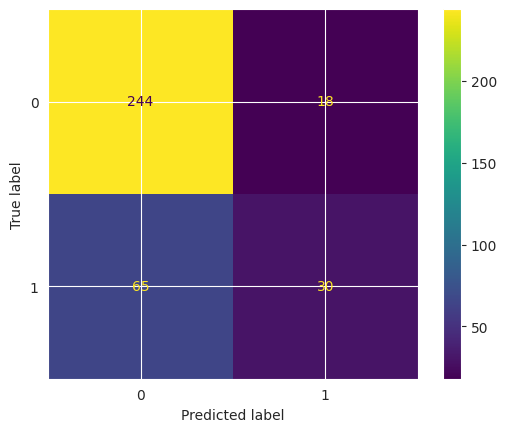

In [327]:
# Define best hyperparameters found by Optuna
best_params = b2c_lgb_best_params

# split the dataframe into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print the shapes of the resulting sets
print("Training set shape: X_train = {}, y_train = {}".format(X_train.shape, y_train.shape))
print("Testing set shape: X_test = {}, y_test = {}".format(X_test.shape, y_test.shape))

y_train_b2c = y_train['B2C'].to_list()
y_train_b2b = y_train['B2B'].to_list()

y_test_b2c = y_test['B2C'].to_list()
y_test_b2b = y_test['B2B'].to_list()

# Train the XGBoost model using the best hyperparameters
model_b2c_lgb = xgb.XGBClassifier(**best_params, gpu_id=device_id)
model_b2c_lgb.fit(X_train, y_train_b2c)

# Make predictions on test data
y_pred_b2c = model_b2c_lgb.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test_b2c, y_pred_b2c)
print("Accuracy score: ", accuracy)

cm = confusion_matrix(y_test_b2c, y_pred_b2c)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### XGBoost
---

In [280]:

# Define objective function to optimize using Optuna
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "verbosity": 0,
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.1, 1.0),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "random_state": 42
    }
    
    # Train and evaluate the model
    model = xgb.XGBClassifier(**params, gpu_id=device_id)
    model.fit(X_train, y_train_b2c)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test_b2c, y_pred)
    return accuracy

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and accuracy score
print("Best hyperparameters: ", study.best_params)
print("Best accuracy score: ", study.best_value)

b2c_xgboost_best_params = study.best_params

[I 2023-04-03 06:22:08,204] A new study created in memory with name: no-name-f170120b-ead7-462f-8a2b-2701aa2e8d05
<ipython-input-280-d47f6a71743a>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-280-d47f6a71743a>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-280-d47f6a71743a>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "colsamp

Best hyperparameters:  {'booster': 'dart', 'lambda': 1.1820990867510495e-07, 'alpha': 0.012347305427417462, 'colsample_bytree': 0.47158703079402403, 'subsample': 0.8666242517977357, 'learning_rate': 0.003571219987399579, 'n_estimators': 481, 'max_depth': 30, 'min_child_weight': 7, 'gamma': 0.0012867030638734414}
Best accuracy score:  0.7871148459383753


Training set shape: X_train = (1424, 84), y_train = (1424, 2)
Testing set shape: X_test = (357, 84), y_test = (357, 2)
Accuracy score:  0.7759103641456583


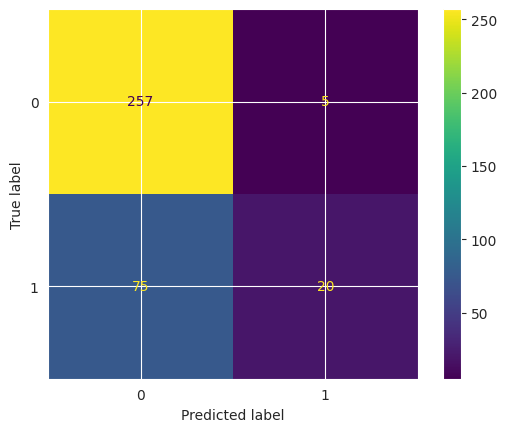

In [299]:
# Define best hyperparameters found by Optuna
best_params = b2c_xgboost_best_params

# split the dataframe into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print the shapes of the resulting sets
print("Training set shape: X_train = {}, y_train = {}".format(X_train.shape, y_train.shape))
print("Testing set shape: X_test = {}, y_test = {}".format(X_test.shape, y_test.shape))

y_train_b2c = y_train['B2C'].to_list()
y_train_b2b = y_train['B2B'].to_list()

y_test_b2c = y_test['B2C'].to_list()
y_test_b2b = y_test['B2B'].to_list()

# Train the XGBoost model using the best hyperparameters
model_b2c_xgb = xgb.XGBClassifier(**best_params, gpu_id=device_id)
model_b2c_xgb.fit(X_train, y_train_b2c)

# Make predictions on test data
y_pred_b2c = model_b2c_xgb.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test_b2c, y_pred_b2c)
print("Accuracy score: ", accuracy)

cm = confusion_matrix(y_test_b2c, y_pred_b2c)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_b2c_xgb.classes_)
disp.plot()
plt.show()

## B2B MODEL

In [332]:
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "num_iterations": trial.suggest_int("num_iterations", 100, 1000),
        "random_state": 42
    }
    
    # Train and evaluate the model
    model = lgb.train(params, lgb.Dataset(X_train_b2b, label=y_train_b2b), valid_sets=[lgb.Dataset(X_test_b2b, label=y_test_b2b)], verbose_eval=False)
    y_pred = model.predict(X_test_b2b)

    accuracy = accuracy_score(y_test_b2b, [1 if p>0.5 else 0 for p in y_pred])
    return accuracy

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and accuracy score
print("Best hyperparameters: ", study.best_params)
print("Best accuracy score: ", study.best_value)

b2b_lgb_best_params = study.best_params

[I 2023-04-03 07:26:15,257] A new study created in memory with name: no-name-df1c3426-ef68-4c56-b676-ff83cf31a1de
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:15,362] Trial 0 finished with value: 0.6323529411764706 and parameters: {'lambda_l1': 7.956117253505723, 'lambda_l2': 5.350491026262235, 'num_leaves': 189, 'learning_rate': 0.6421870991092343, 'feature_fraction': 0.435479519322164, 'bagging_fraction': 0.7720186549605442, 'bagging_freq': 6, 'min_child_s

[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=68


[I 2023-04-03 07:26:15,600] Trial 5 finished with value: 0.6764705882352942 and parameters: {'lambda_l1': 3.6124626901449397, 'lambda_l2': 6.46686964367458, 'num_leaves': 55, 'learning_rate': 0.11956477117292223, 'feature_fraction': 0.1008981578143285, 'bagging_fraction': 0.48100969178283615, 'bagging_freq': 5, 'min_child_samples': 76, 'min_data_in_leaf': 68, 'max_depth': 26, 'num_iterations': 583}. Best is trial 4 with value: 0.6911764705882353.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release o

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=70


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:15,854] Trial 10 finished with value: 0.6470588235294118 and parameters: {'lambda_l1': 9.958606454338288, 'lambda_l2': 9.3465587802994, 'num_leaves': 104, 'learning_rate': 0.98916263912792, 'feature_fraction': 0.6774052349861306, 'bagging_fraction': 0.9371446323607848, 'bagging_freq': 2, 'min_child_samples': 48, 'min_data_in_leaf': 74, 'max_depth': 15, 'num_iterations': 114}. Best is trial 9 with value: 0.70588235

[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=37


[I 2023-04-03 07:26:16,118] Trial 12 finished with value: 0.6323529411764706 and parameters: {'lambda_l1': 1.267660857785716, 'lambda_l2': 2.4358344376349397, 'num_leaves': 105, 'learning_rate': 0.9943049890340705, 'feature_fraction': 0.4569790630493796, 'bagging_fraction': 0.43991690630880864, 'bagging_freq': 2, 'min_child_samples': 10, 'min_data_in_leaf': 37, 'max_depth': 17, 'num_iterations': 877}. Best is trial 9 with value: 0.7058823529411765.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=56


[I 2023-04-03 07:26:16,390] Trial 14 finished with value: 0.6323529411764706 and parameters: {'lambda_l1': 0.057545162012291096, 'lambda_l2': 3.807480442518056, 'num_leaves': 146, 'learning_rate': 0.8831968117468051, 'feature_fraction': 0.6544602192582246, 'bagging_fraction': 0.5661138105851368, 'bagging_freq': 3, 'min_child_samples': 24, 'min_data_in_leaf': 56, 'max_depth': 11, 'num_iterations': 438}. Best is trial 9 with value: 0.7058823529411765.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=77


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:16,703] Trial 17 finished with value: 0.4264705882352941 and parameters: {'lambda_l1': 1.0373031056186492, 'lambda_l2': 1.72688018150837, 'num_leaves': 75, 'learning_rate': 0.8181036293184656, 'feature_fraction': 0.9990691970466995, 'bagging_fraction': 0.5220247610809488, 'bagging_freq': 4, 'min_child_samples': 40, 'min_data_in_leaf': 83, 'max_depth': 12, 'num_iterations': 686}. Best is trial 16 with value: 0.75.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=82


[I 2023-04-03 07:26:16,889] Trial 19 finished with value: 0.6323529411764706 and parameters: {'lambda_l1': 2.452691671970848, 'lambda_l2': 0.05288634321032726, 'num_leaves': 70, 'learning_rate': 0.5575853241764837, 'feature_fraction': 0.6470056070648812, 'bagging_fraction': 0.6667779625699115, 'bagging_freq': 2, 'min_child_samples': 38, 'min_data_in_leaf': 82, 'max_depth': 14, 'num_iterations': 352}. Best is trial 16 with value: 0.75.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. 

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=45


[I 2023-04-03 07:26:17,157] Trial 21 finished with value: 0.6764705882352942 and parameters: {'lambda_l1': 3.0675929954271632, 'lambda_l2': 3.050471471803575, 'num_leaves': 110, 'learning_rate': 0.9025605066995561, 'feature_fraction': 0.5593733282600278, 'bagging_fraction': 0.3509418608999232, 'bagging_freq': 3, 'min_child_samples': 26, 'min_data_in_leaf': 45, 'max_depth': 20, 'num_iterations': 991}. Best is trial 16 with value: 0.75.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. 

[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=18


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:17,503] Trial 24 finished with value: 0.5588235294117647 and parameters: {'lambda_l1': 2.725136752384635, 'lambda_l2': 3.8735427743445303, 'num_leaves': 121, 'learning_rate': 0.804587715055472, 'feature_fraction': 0.39774216145295305, 'bagging_fraction': 0.385043129533216, 'bagging_freq': 1, 'min_child_samples': 51, 'min_data_in_leaf': 47, 'max_depth': 10, 'num_iterations': 546}. Best is trial 16 with value: 0.75.

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=63


[I 2023-04-03 07:26:17,656] Trial 25 finished with value: 0.6470588235294118 and parameters: {'lambda_l1': 0.7249291335146062, 'lambda_l2': 2.66688664693896, 'num_leaves': 162, 'learning_rate': 0.8804092978695158, 'feature_fraction': 0.5199388742804079, 'bagging_fraction': 0.5137014064145722, 'bagging_freq': 5, 'min_child_samples': 34, 'min_data_in_leaf': 63, 'max_depth': 16, 'num_iterations': 915}. Best is trial 16 with value: 0.75.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=27


[I 2023-04-03 07:26:17,927] Trial 28 finished with value: 0.6617647058823529 and parameters: {'lambda_l1': 0.040255785694617074, 'lambda_l2': 2.054451500305823, 'num_leaves': 90, 'learning_rate': 0.9986855626498103, 'feature_fraction': 0.3251138863578732, 'bagging_fraction': 0.4191028370772305, 'bagging_freq': 4, 'min_child_samples': 66, 'min_data_in_leaf': 27, 'max_depth': 22, 'num_iterations': 269}. Best is trial 16 with value: 0.75.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM.

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=74


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:18,273] Trial 31 finished with value: 0.4411764705882353 and parameters: {'lambda_l1': 2.913043617554041, 'lambda_l2': 2.8816976830131087, 'num_leaves': 124, 'learning_rate': 0.9153637750916344, 'feature_fraction': 0.45083860886721405, 'bagging_fraction': 0.46525146578308313, 'bagging_freq': 3, 'min_child_samples': 42, 'min_data_in_leaf': 77, 'max_depth': 22, 'num_iterations': 831}. Best is trial 16 with value: 0.

[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=67


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:18,515] Trial 33 finished with value: 0.4264705882352941 and parameters: {'lambda_l1': 3.828346241301931, 'lambda_l2': 4.4195261897439515, 'num_leaves': 149, 'learning_rate': 0.9225651929170442, 'feature_fraction': 0.4201498348043351, 'bagging_fraction': 0.5787173518437345, 'bagging_freq': 4, 'min_child_samples': 55, 'min_data_in_leaf': 91, 'max_depth': 27, 'num_iterations': 864}. Best is trial 16 with value: 0.75

[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=71


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:18,748] Trial 35 finished with value: 0.5 and parameters: {'lambda_l1': 5.054991598600047, 'lambda_l2': 1.0454742102838723, 'num_leaves': 32, 'learning_rate': 0.9422909640358837, 'feature_fraction': 0.6117284120300807, 'bagging_fraction': 0.3691915854790603, 'bagging_freq': 3, 'min_child_samples': 31, 'min_data_in_leaf': 62, 'max_depth': 22, 'num_iterations': 766}. Best is trial 16 with value: 0.75.
/usr/local/lib

[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=79


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:18,961] Trial 37 finished with value: 0.4411764705882353 and parameters: {'lambda_l1': 0.7126986681476043, 'lambda_l2': 2.5496186670035215, 'num_leaves': 136, 'learning_rate': 0.6379990004313909, 'feature_fraction': 0.27052577655538296, 'bagging_fraction': 0.2232084282000082, 'bagging_freq': 2, 'min_child_samples': 37, 'min_data_in_leaf': 88, 'max_depth': 11, 'num_iterations': 596}. Best is trial 16 with value: 0.

[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=17


[I 2023-04-03 07:26:19,168] Trial 39 finished with value: 0.6470588235294118 and parameters: {'lambda_l1': 3.132953075092287, 'lambda_l2': 3.456304972614789, 'num_leaves': 50, 'learning_rate': 0.7726864221890036, 'feature_fraction': 0.7453169803741677, 'bagging_fraction': 0.4850679837655793, 'bagging_freq': 5, 'min_child_samples': 44, 'min_data_in_leaf': 17, 'max_depth': 19, 'num_iterations': 664}. Best is trial 16 with value: 0.75.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:19,550] Trial 42 finished with value: 0.5735294117647058 and parameters: {'lambda_l1': 4.095322281706059, 'lambda_l2': 2.780483422962453, 'num_leaves': 96, 'learning_rate': 0.802858538492799, 'feature_fraction': 0.4800236051575638, 'bagging_fraction': 0.16221408863483078, 'bagging_freq': 3, 'min_child_samples': 11, 'min_data_in_leaf': 16, 'max_depth': 24, 'num_iterations': 861}. Best is trial 16 with value: 0.75.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=72


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:19,788] Trial 44 finished with value: 0.6176470588235294 and parameters: {'lambda_l1': 1.5038285713855077, 'lambda_l2': 4.4427643088804505, 'num_leaves': 251, 'learning_rate': 0.9460536706014544, 'feature_fraction': 0.5227262650025495, 'bagging_fraction': 0.29901391010169964, 'bagging_freq': 6, 'min_child_samples': 48, 'min_data_in_leaf': 41, 'max_depth': 15, 'num_iterations': 723}. Best is trial 16 with value: 0.

[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=14


[I 2023-04-03 07:26:19,954] Trial 45 finished with value: 0.5882352941176471 and parameters: {'lambda_l1': 2.0070720658285306, 'lambda_l2': 3.8671940632376636, 'num_leaves': 154, 'learning_rate': 0.7348233067528207, 'feature_fraction': 0.691363454868214, 'bagging_fraction': 0.1658540719750356, 'bagging_freq': 5, 'min_child_samples': 36, 'min_data_in_leaf': 14, 'max_depth': 18, 'num_iterations': 627}. Best is trial 16 with value: 0.75.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. 

[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=97


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:20,339] Trial 48 finished with value: 0.5588235294117647 and parameters: {'lambda_l1': 1.3080492550430876, 'lambda_l2': 2.094076497187014, 'num_leaves': 108, 'learning_rate': 0.8802277090854559, 'feature_fraction': 0.4767896250734676, 'bagging_fraction': 0.5494024673475799, 'bagging_freq': 3, 'min_child_samples': 13, 'min_data_in_leaf': 10, 'max_depth': 23, 'num_iterations': 458}. Best is trial 16 with value: 0.75

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:20,564] Trial 50 finished with value: 0.6617647058823529 and parameters: {'lambda_l1': 3.4484778952561204, 'lambda_l2': 4.980850833052985, 'num_leaves': 81, 'learning_rate': 0.6969309484548135, 'feature_fraction': 0.6562093513501872, 'bagging_fraction': 0.6459311876537889, 'bagging_freq': 3, 'min_child_samples': 46, 'min_data_in_leaf': 22, 'max_depth': 27, 'num_iterations': 514}. Best is trial 16 with value: 0.75.

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=33


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:20,807] Trial 52 finished with value: 0.6617647058823529 and parameters: {'lambda_l1': 2.6360051251586816, 'lambda_l2': 4.1497892735319795, 'num_leaves': 39, 'learning_rate': 0.9058957504915173, 'feature_fraction': 0.5396107231595314, 'bagging_fraction': 0.6087868729451323, 'bagging_freq': 4, 'min_child_samples': 22, 'min_data_in_leaf': 33, 'max_depth': 25, 'num_iterations': 611}. Best is trial 16 with value: 0.75

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=38


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:21,023] Trial 54 finished with value: 0.6764705882352942 and parameters: {'lambda_l1': 4.051906297178786, 'lambda_l2': 2.990169396306943, 'num_leaves': 24, 'learning_rate': 0.8471919650694681, 'feature_fraction': 0.5614144654014461, 'bagging_fraction': 0.562322046683173, 'bagging_freq': 5, 'min_child_samples': 20, 'min_data_in_leaf': 22, 'max_depth': 24, 'num_iterations': 427}. Best is trial 16 with value: 0.75.
/

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=31


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:21,272] Trial 56 finished with value: 0.6617647058823529 and parameters: {'lambda_l1': 1.6685428918121927, 'lambda_l2': 2.423782286181407, 'num_leaves': 18, 'learning_rate': 0.9013756370017509, 'feature_fraction': 0.47037832907161203, 'bagging_fraction': 0.4573792068559843, 'bagging_freq': 3, 'min_child_samples': 8, 'min_data_in_leaf': 32, 'max_depth': 9, 'num_iterations': 186}. Best is trial 16 with value: 0.75.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=40


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:21,583] Trial 58 finished with value: 0.6029411764705882 and parameters: {'lambda_l1': 0.7632486752557011, 'lambda_l2': 3.7475224524270763, 'num_leaves': 39, 'learning_rate': 0.8351865612764855, 'feature_fraction': 0.4509800377850843, 'bagging_fraction': 0.4959156432019381, 'bagging_freq': 3, 'min_child_samples': 15, 'min_data_in_leaf': 51, 'max_depth': 9, 'num_iterations': 688}. Best is trial 16 with value: 0.75.

[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=84


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:21,794] Trial 60 finished with value: 0.5441176470588235 and parameters: {'lambda_l1': 1.1596340600021096, 'lambda_l2': 2.7261442760069556, 'num_leaves': 75, 'learning_rate': 0.9658075760342129, 'feature_fraction': 0.5116616411136321, 'bagging_fraction': 0.39827209291008314, 'bagging_freq': 2, 'min_child_samples': 25, 'min_data_in_leaf': 66, 'max_depth': 7, 'num_iterations': 576}. Best is trial 16 with value: 0.75

[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=28


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:22,032] Trial 62 finished with value: 0.6617647058823529 and parameters: {'lambda_l1': 2.954206252445381, 'lambda_l2': 4.790856199247764, 'num_leaves': 99, 'learning_rate': 0.7818305818303951, 'feature_fraction': 0.6200026832146677, 'bagging_fraction': 0.5308165446477585, 'bagging_freq': 4, 'min_child_samples': 18, 'min_data_in_leaf': 34, 'max_depth': 13, 'num_iterations': 472}. Best is trial 16 with value: 0.75.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=80


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:22,275] Trial 64 finished with value: 0.7058823529411765 and parameters: {'lambda_l1': 1.8564235751187659, 'lambda_l2': 4.309219389658144, 'num_leaves': 54, 'learning_rate': 0.9255700708066538, 'feature_fraction': 0.54174721120006, 'bagging_fraction': 0.6362954639236276, 'bagging_freq': 3, 'min_child_samples': 34, 'min_data_in_leaf': 20, 'max_depth': 5, 'num_iterations': 554}. Best is trial 16 with value: 0.75.
/u

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=44


[I 2023-04-03 07:26:22,417] Trial 65 finished with value: 0.6617647058823529 and parameters: {'lambda_l1': 3.3101682784815782, 'lambda_l2': 4.713529549108223, 'num_leaves': 135, 'learning_rate': 0.8723010242395425, 'feature_fraction': 0.45564031918178044, 'bagging_fraction': 0.45031304895250357, 'bagging_freq': 4, 'min_child_samples': 61, 'min_data_in_leaf': 44, 'max_depth': 23, 'num_iterations': 491}. Best is trial 16 with value: 0.75.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=29


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:22,829] Trial 68 finished with value: 0.5882352941176471 and parameters: {'lambda_l1': 3.6205459482380875, 'lambda_l2': 3.529254400401401, 'num_leaves': 114, 'learning_rate': 0.9230874924107586, 'feature_fraction': 0.5359277577163123, 'bagging_fraction': 0.5152158783249378, 'bagging_freq': 4, 'min_child_samples': 51, 'min_data_in_leaf': 25, 'max_depth': 14, 'num_iterations': 838}. Best is trial 16 with value: 0.75

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=64


[I 2023-04-03 07:26:22,991] Trial 69 finished with value: 0.6029411764705882 and parameters: {'lambda_l1': 1.6970331815483832, 'lambda_l2': 4.467253128404775, 'num_leaves': 84, 'learning_rate': 0.8500582561188263, 'feature_fraction': 0.4975579676297619, 'bagging_fraction': 0.5812265051518701, 'bagging_freq': 3, 'min_child_samples': 33, 'min_data_in_leaf': 64, 'max_depth': 28, 'num_iterations': 793}. Best is trial 16 with value: 0.75.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:23,396] Trial 72 finished with value: 0.6323529411764706 and parameters: {'lambda_l1': 2.2013508564113735, 'lambda_l2': 4.334586139601315, 'num_leaves': 32, 'learning_rate': 0.957973240172147, 'feature_fraction': 0.6098082615037054, 'bagging_fraction': 0.6838759304215002, 'bagging_freq': 3, 'min_child_samples': 35, 'min_data_in_leaf': 72, 'max_depth': 5, 'num_iterations': 661}. Best is trial 16 with value: 0.75.
/

[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=15


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:23,659] Trial 74 finished with value: 0.6323529411764706 and parameters: {'lambda_l1': 1.3583283380809976, 'lambda_l2': 2.586301573125376, 'num_leaves': 49, 'learning_rate': 0.9244063152924817, 'feature_fraction': 0.5247119966323399, 'bagging_fraction': 0.7195028215016106, 'bagging_freq': 3, 'min_child_samples': 33, 'min_data_in_leaf': 19, 'max_depth': 6, 'num_iterations': 625}. Best is trial 16 with value: 0.75.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=26


[I 2023-04-03 07:26:23,798] Trial 75 finished with value: 0.6323529411764706 and parameters: {'lambda_l1': 1.809954855355187, 'lambda_l2': 3.5888340214215035, 'num_leaves': 74, 'learning_rate': 0.8367864979060202, 'feature_fraction': 0.46501658097688564, 'bagging_fraction': 0.5076515076694984, 'bagging_freq': 4, 'min_child_samples': 25, 'min_data_in_leaf': 26, 'max_depth': 12, 'num_iterations': 559}. Best is trial 16 with value: 0.75.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. 

[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=58


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:24,178] Trial 78 finished with value: 0.6323529411764706 and parameters: {'lambda_l1': 3.355983132201305, 'lambda_l2': 1.8829712577940856, 'num_leaves': 39, 'learning_rate': 0.9301107395162727, 'feature_fraction': 0.4442766103514499, 'bagging_fraction': 0.4296392419745168, 'bagging_freq': 3, 'min_child_samples': 39, 'min_data_in_leaf': 23, 'max_depth': 18, 'num_iterations': 713}. Best is trial 16 with value: 0.75.

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=12


[I 2023-04-03 07:26:24,352] Trial 79 finished with value: 0.6470588235294118 and parameters: {'lambda_l1': 2.4722255526772905, 'lambda_l2': 4.611467191425799, 'num_leaves': 27, 'learning_rate': 0.8642295108871785, 'feature_fraction': 0.48458958589522755, 'bagging_fraction': 0.5365906368165032, 'bagging_freq': 2, 'min_child_samples': 16, 'min_data_in_leaf': 12, 'max_depth': 26, 'num_iterations': 972}. Best is trial 16 with value: 0.75.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. 

[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=5


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:24,760] Trial 82 finished with value: 0.6029411764705882 and parameters: {'lambda_l1': 2.3883664924886796, 'lambda_l2': 3.350035960811856, 'num_leaves': 71, 'learning_rate': 0.9518826489770879, 'feature_fraction': 0.5502627780754267, 'bagging_fraction': 0.3552695175830062, 'bagging_freq': 7, 'min_child_samples': 20, 'min_data_in_leaf': 7, 'max_depth': 19, 'num_iterations': 673}. Best is trial 16 with value: 0.75.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=13


[I 2023-04-03 07:26:24,905] Trial 83 finished with value: 0.6617647058823529 and parameters: {'lambda_l1': 3.63959794504098, 'lambda_l2': 4.1275611100531835, 'num_leaves': 64, 'learning_rate': 0.7806263859187793, 'feature_fraction': 0.5139901802005616, 'bagging_fraction': 0.627205233538041, 'bagging_freq': 5, 'min_child_samples': 23, 'min_data_in_leaf': 13, 'max_depth': 23, 'num_iterations': 781}. Best is trial 16 with value: 0.75.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=70


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:25,276] Trial 86 finished with value: 0.6617647058823529 and parameters: {'lambda_l1': 2.1015410934091827, 'lambda_l2': 3.1083033762917607, 'num_leaves': 144, 'learning_rate': 0.9019969055691281, 'feature_fraction': 0.7197047959934498, 'bagging_fraction': 0.4946622217430974, 'bagging_freq': 3, 'min_child_samples': 37, 'min_data_in_leaf': 79, 'max_depth': 3, 'num_iterations': 578}. Best is trial 16 with value: 0.75

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=36


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:25,561] Trial 88 finished with value: 0.75 and parameters: {'lambda_l1': 1.6561999672839365, 'lambda_l2': 1.5633609683573286, 'num_leaves': 111, 'learning_rate': 0.9763286414347899, 'feature_fraction': 0.5760002882233453, 'bagging_fraction': 0.4298305455093689, 'bagging_freq': 4, 'min_child_samples': 42, 'min_data_in_leaf': 21, 'max_depth': 8, 'num_iterations': 534}. Best is trial 16 with value: 0.75.
/usr/local/l

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=11


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:25,801] Trial 90 finished with value: 0.6764705882352942 and parameters: {'lambda_l1': 2.6964502974760722, 'lambda_l2': 1.524520214331374, 'num_leaves': 125, 'learning_rate': 0.9558233087752006, 'feature_fraction': 0.6139405048276477, 'bagging_fraction': 0.45954857729280724, 'bagging_freq': 4, 'min_child_samples': 47, 'min_data_in_leaf': 8, 'max_depth': 24, 'num_iterations': 536}. Best is trial 16 with value: 0.75

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=20


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:26,062] Trial 92 finished with value: 0.5882352941176471 and parameters: {'lambda_l1': 0.9469879531453093, 'lambda_l2': 2.537324796978443, 'num_leaves': 45, 'learning_rate': 0.9151770471102626, 'feature_fraction': 0.5259823563380285, 'bagging_fraction': 0.4398636299090327, 'bagging_freq': 3, 'min_child_samples': 35, 'min_data_in_leaf': 17, 'max_depth': 7, 'num_iterations': 615}. Best is trial 16 with value: 0.75.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=30


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:26,321] Trial 94 finished with value: 0.7794117647058824 and parameters: {'lambda_l1': 1.2766239397935517, 'lambda_l2': 2.8792705876326266, 'num_leaves': 101, 'learning_rate': 0.8733502183947504, 'feature_fraction': 0.5428378560891012, 'bagging_fraction': 0.46996971994553377, 'bagging_freq': 4, 'min_child_samples': 29, 'min_data_in_leaf': 27, 'max_depth': 23, 'num_iterations': 590}. Best is trial 94 with value: 0.

[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=27


[I 2023-04-03 07:26:26,482] Trial 95 finished with value: 0.6470588235294118 and parameters: {'lambda_l1': 0.4969496621465478, 'lambda_l2': 2.7861103859435543, 'num_leaves': 103, 'learning_rate': 0.866155176406299, 'feature_fraction': 0.5015264063819468, 'bagging_fraction': 0.47522792498192035, 'bagging_freq': 4, 'min_child_samples': 29, 'min_data_in_leaf': 27, 'max_depth': 23, 'num_iterations': 693}. Best is trial 94 with value: 0.7794117647058824.
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=38


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-04-03 07:26:26,928] Trial 98 finished with value: 0.5882352941176471 and parameters: {'lambda_l1': 1.4203452188818655, 'lambda_l2': 1.7596081844475995, 'num_leaves': 107, 'learning_rate': 0.9699896491649251, 'feature_fraction': 0.5618939071980839, 'bagging_fraction': 0.4412423127020993, 'bagging_freq': 4, 'min_child_samples': 26, 'min_data_in_leaf': 37, 'max_depth': 21, 'num_iterations': 902}. Best is trial 94 with value: 0.7

[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=43


[I 2023-04-03 07:26:27,112] Trial 99 finished with value: 0.5882352941176471 and parameters: {'lambda_l1': 1.0243898835834258, 'lambda_l2': 2.1538361452255113, 'num_leaves': 102, 'learning_rate': 0.8955823823674236, 'feature_fraction': 0.5981964942224854, 'bagging_fraction': 0.41282249469211574, 'bagging_freq': 4, 'min_child_samples': 18, 'min_data_in_leaf': 43, 'max_depth': 19, 'num_iterations': 944}. Best is trial 94 with value: 0.7794117647058824.


Best hyperparameters:  {'lambda_l1': 1.2766239397935517, 'lambda_l2': 2.8792705876326266, 'num_leaves': 101, 'learning_rate': 0.8733502183947504, 'feature_fraction': 0.5428378560891012, 'bagging_fraction': 0.46996971994553377, 'bagging_freq': 4, 'min_child_samples': 29, 'min_data_in_leaf': 27, 'max_depth': 23, 'num_iterations': 590}
Best accuracy score:  0.7794117647058824


Training set shape: X_train = (1424, 84), y_train = (1424, 2)
Testing set shape: X_test = (357, 84), y_test = (357, 2)
[07:26:34] WARNING: ../src/learner.cc:767: 
Parameters: { "bagging_fraction", "bagging_freq", "feature_fraction", "lambda_l1", "lambda_l2", "min_child_samples", "min_data_in_leaf", "num_iterations", "num_leaves" } are not used.

Accuracy score:  0.9047619047619048


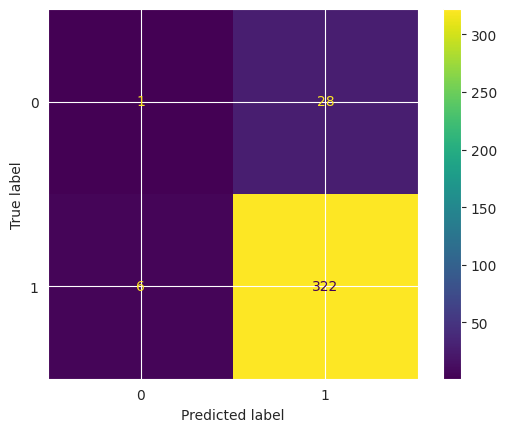

In [333]:
# Define best hyperparameters found by Optuna
best_params = b2b_lgb_best_params

# split the dataframe into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print the shapes of the resulting sets
print("Training set shape: X_train = {}, y_train = {}".format(X_train.shape, y_train.shape))
print("Testing set shape: X_test = {}, y_test = {}".format(X_test.shape, y_test.shape))

y_train_b2c = y_train['B2C'].to_list()
y_train_b2b = y_train['B2B'].to_list()

y_test_b2c = y_test['B2C'].to_list()
y_test_b2b = y_test['B2B'].to_list()

# Train the XGBoost model using the best hyperparameters
model_b2b_lgb = xgb.XGBClassifier(**best_params, gpu_id=device_id)
model_b2b_lgb.fit(X_train, y_train_b2b)

# Make predictions on test data
y_pred_b2b = model_b2b_lgb.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test_b2b, y_pred_b2b)
print("Accuracy score: ", accuracy)

cm = confusion_matrix(y_test_b2b, y_pred_b2b)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_b2b_lgb.classes_)
disp.plot()
plt.show()